# PIPELINE PER A L’AUTOMATITZACIÓ DE LA CATEGORITZACIÓ I EL SEGUIMENT DEL SERVEI DE CONGELACIÓ I CRIOPRESERVACIÓ


**Objectiu del codi:** Classificar els grups usuaris del Servei de Congelació i Criopreservació en tres classes: Actiu PRO, Actiu i Inactiu.


**Mètode:** Es dividiran els grups usuaris segons si són Fons Biobanc, línies d'investigació A3 o línies d'investigació A0, i es definiran uns llindars per a cada variable segons l'*Anàlisi de l'activitat i proposta de criteris de repercussió de costos per al Servei de Congelació i Criopreservació de mostres a IDIBAPS (2022)*.

Amb aquests llindars, es detectarà per a cada grup a quina cateogoria s'adeqüen.

## 1. DISSENY I PREPARACIÓ

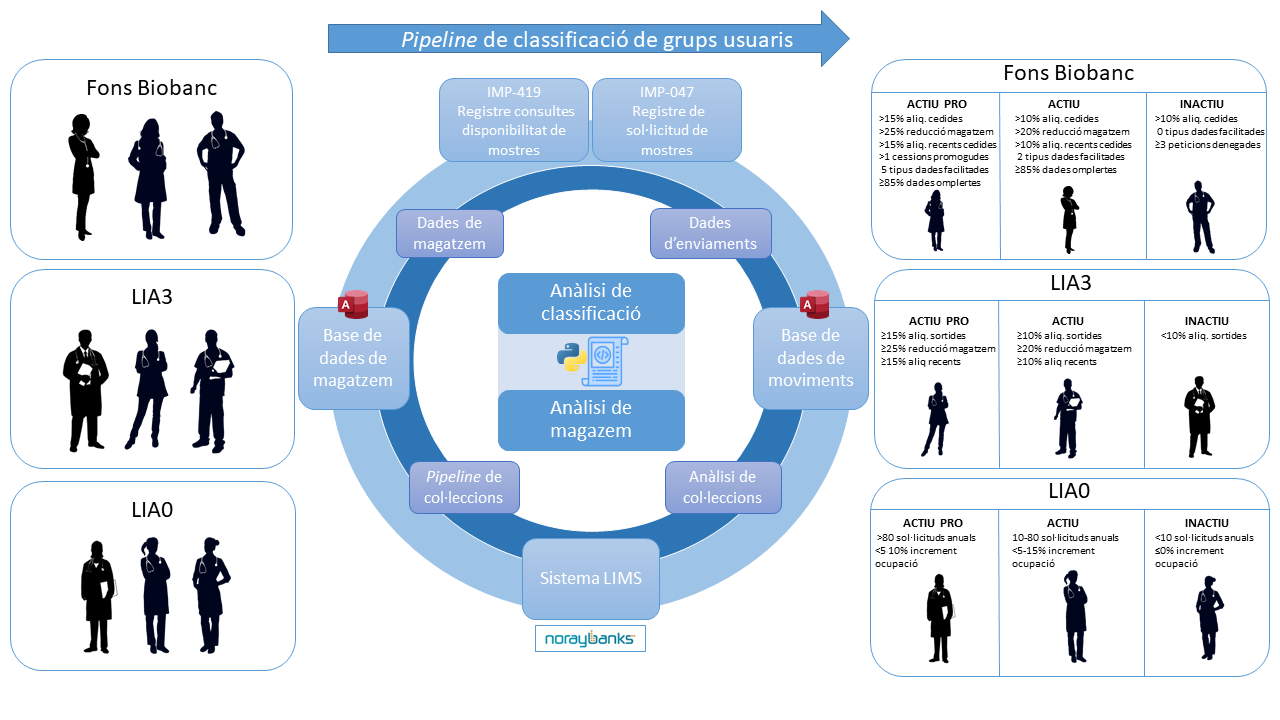

In [1]:
# Els documents amb els què treballarem els trobem en la següent figura
from IPython.display import Image # Per tal de poder veure la figura desde el directori
Image(filename='C:/Users/ferra/OneDrive/Escritorio/Imatge figura tfm2 final.png')

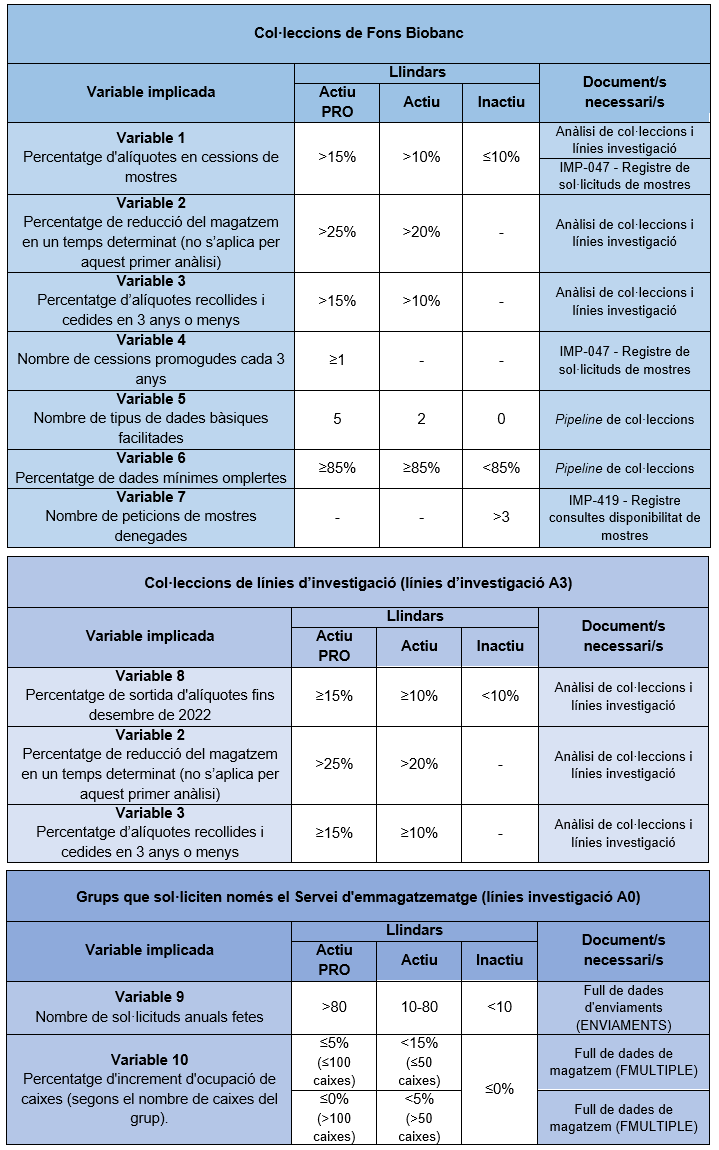

In [2]:
# I els llindars i variables necessaris, els trobem a les següents taules:
Image(filename='C:/Users/ferra/OneDrive/Escritorio/LLINDARS.png')

## 2. IMPORTACIÓ DE DADES

### PAQUETS UTILITZATS

In [5]:
# Paquet que permet diverses funcions per a l'anàlisi de dades, com per exemple la descàrrega d'arxius del nostre directori, o vàries operacions amb dataframes.
import pandas as pd

# Paquet per anotar i operar amb dates.
from datetime import date

# Paquet que permet realitzar gràfics.
import matplotlib.pyplot as plt
# Sub-paquet de matplotlib que permet realitzar i canviar diferents característiques dels gràfics.
import pylab

# Paquet per realitzar operacions matemàtiques sobre arrays. 
import numpy as np

# Per no mostrar els errors en vermell.
import warnings
warnings.filterwarnings("ignore")

### DATAFRAMES

En tots els casos s'importaran els documents en format xls (full de dades), es trauran les files innecessàries i es visualitzarà el resultat. Per aquest treball no executarem la visualització de tots els casos (que es fa mitjançant el comandament head) per tal de no sobreescriure el document. En alguns casos s'ometrà la presentació de dades (tot i que es mantindrà el codi psudonimitzat) degut a la presència de dades sensibles, com els noms dels investigadors principals, donants o altres dades semblants.

A continuació, per cada *dataframe*, s'explicarà **el seu contingut** i es faran els canvis oportuns per tal de poder operar còmodament.

De totes les dades disponibles, diferenciarem les **variables necessàries** per a realitzar la distinció entre grups, i anotarem algunes **variables complementàries** que poden ser informatives de cara a pròxims canvis de la *pipeline*.

### <span style="color:lightskyblue"> 2.1. Anàlisi de col·leccions i línies investigació </span>



**2.1.1. DESCRIPCIÓ**

Aquest arxiu de tipus xls (Excel, full de dades) és un recull del total de les mostres que té cada col·lecció de fons Biobanc i línies d'investigació d'àrea 3 (A3) per tipus de mostra (sèrum, PBMCs, sang, etc), especificant quantes alíquotes de cada tipus hi ha anotades a la base de dades (LIMS) del Biobanc. A més, s'hi anoten els càlculs de cessions per els últims tres anys (dades recents). Aquest arxiu depèn de les exportacions de la base de dades (LIMS), i, per tant caldrà actualitzar-lo periòdicament. **Cada fila conté una col·lecció o línia d'investigació d'A3 diferent**. 

**2.1.2. VARIABLES NECESSÀRIES**

Aquest document té diferents pestanyes amb informació rellevant.

- **Col·lecció/Línia investigació(o servei)**: Variable camp de text. Informa de la col·lecció o línia d'investigació a la que es refereix la informació de la fila.

- **Tipus de mostra**: Variable de tipus numèrica. Registra el total d'alíquotes de cada tipus (Sèrum, EDTA plasma, orina...).

- **TOTAL**: Variable numèrica. Informa del total de mostres que té cada col·lecció, per tipus. 

- **% aliq recents cedides**: Variable numèrica de tipus percentatge. Informa del total d'alíquotes cedides de menys de tres anys respecte el total d'alíquotes recents al biobanc (menys de tres anys).

- **Data inici recollida**: Variable de tipus data. Registra la data de la primera recollida de mostres de la col·lecció.

**2.1.3. VARIABLES COMPLEMENTÀRIES**

En aquest document no hi ha variables que aportin informació addicional rellevant.

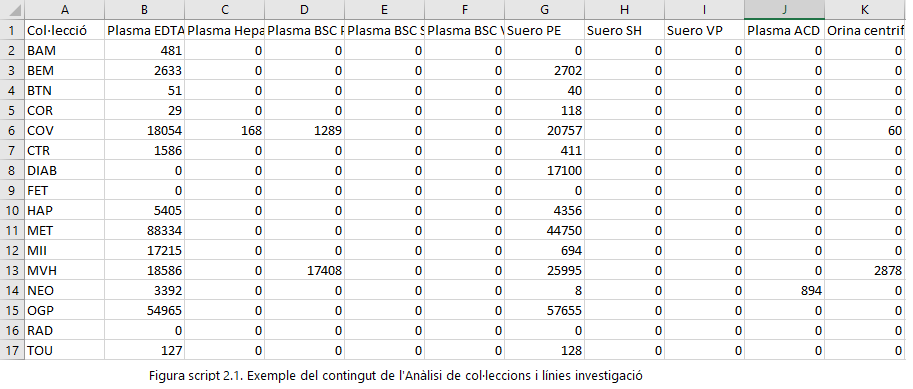

In [6]:
# Importem l'imprès. Té diferents pestanyes interessants

# PESTANYES SOBRE TOTALS D'ALÍQUOTES: una amb l'anàlisi del Fons Biobanc i l'altra, per les línies A3.
# Per FONS BIOBANC:
ANALISICOLS_FBB = pd.read_excel("C:/Users/ferra/Downloads/Anàlisi coleccions FBB i serveis A3.xlsx", 'FONS BIOBANC', header=0)
# Per LI-A3:
ANALISICOLS_LIA3 = pd.read_excel("C:/Users/ferra/Downloads/Anàlisi coleccions FBB i serveis A3.xlsx", 'LINIES A3', header=0)
# Per informació addicional del Fons Biobanc:
ANALISICOLS_INFOADD = pd.read_excel("C:/Users/ferra/Downloads/Anàlisi coleccions FBB i serveis A3.xlsx", 'informació general', header=0)

# PESTANYES SOBRE TOTALS D'ALIQUOTES I ALÍQUOTES CEDIDES RECENTS (3 anys)
# Per FONS BIOBANC:
ANALISICOLS_FBB_3anys = pd.read_excel("C:/Users/ferra/Downloads/Anàlisi coleccions FBB i serveis A3.xlsx", 'Info alíq recents (3anys) FBB', header=0)
# Per LI-A3:
ANALISICOLS_LIA3_3anys = pd.read_excel("C:/Users/ferra/Downloads/Anàlisi coleccions FBB i serveis A3.xlsx", 'Info alíq recents (3anys) SA3', header=0)

# 1) Seleccionem les variables que ens interessen:
ANALISICOLS_FBB = ANALISICOLS_FBB[['Col·lecció','TOTAL']]
ANALISICOLS_LIA3 = ANALISICOLS_LIA3[['Línia A3','TOTAL']]
ANALISICOLS_INFOADD = ANALISICOLS_INFOADD[['Acrònim NorayBanks (NB)','Data inici recollida']]

# 2) Treiem col·leccions que no són d'àrea 3 (sense mostres líquides únicament) o que no s'analitzen en el semestre actual
ANALISICOLS_FBB = ANALISICOLS_FBB.drop(ANALISICOLS_FBB[ANALISICOLS_FBB['Col·lecció'] == "BTN"].index)
ANALISICOLS_FBB = ANALISICOLS_FBB.drop(ANALISICOLS_FBB[ANALISICOLS_FBB['Col·lecció'] == "FET"].index)
ANALISICOLS_INFOADD = ANALISICOLS_INFOADD.drop(ANALISICOLS_INFOADD[ANALISICOLS_INFOADD['Acrònim NorayBanks (NB)'] == "BTN"].index)
ANALISICOLS_INFOADD = ANALISICOLS_INFOADD.drop(ANALISICOLS_INFOADD[ANALISICOLS_INFOADD['Acrònim NorayBanks (NB)'] == "FET"].index)
ANALISICOLS_INFOADD = ANALISICOLS_INFOADD.drop(ANALISICOLS_INFOADD[ANALISICOLS_INFOADD['Acrònim NorayBanks (NB)'] == "BTT"].index)
ANALISICOLS_FBB_3anys = ANALISICOLS_FBB_3anys.drop(ANALISICOLS_FBB_3anys[ANALISICOLS_FBB_3anys['Col·lecció'] == "BTN"].index)
ANALISICOLS_FBB_3anys = ANALISICOLS_FBB_3anys.drop(ANALISICOLS_FBB_3anys[ANALISICOLS_FBB_3anys['Col·lecció'] == "FET"].index)

# 3) Pseudonimització
# En el cas de les línies d'investigació d'Àrea 3, es treballa amb usuaris particulars, pel que s'hauran de pseudonimitzar.
# En un full extern, assignarem un número correlatiu a cada servei. Aquest codi serà el que es mostrarà per aquest treball.
LIA3_ANON = pd.read_excel("C:/Users/ferra/Downloads/serveis a3 a0 anon.xlsx",'A3', header=0)
# Juntem els noms dels serveis al dataframe original amb el dels codis de pseudonimització.
ANALISICOLS_LIA3 = pd.merge(ANALISICOLS_LIA3, LIA3_ANON, on="Línia A3")
ANALISICOLS_LIA3_3anys = pd.merge(ANALISICOLS_LIA3_3anys, LIA3_ANON, on="Línia A3")

# Ara tindrem una columna amb els noms visibles, que no ensenyarem en aquest projecte (Línia A3), i una columna amb els noms pseudonimitzats (Línia A3 (anon)).
# En aquest anàlisi falten col·leccions molt antigues i les més noves. Per tant, no es podrà calcular aquesta variable per aquestes col·leccions.

# Exemple visual del document
Image(filename='C:/Users/ferra/OneDrive/Escritorio/FIG21.png')

### <span style="color:orange"> 2.2. IMP-047 - Registre de sol·licituds de mostres</span>

**2.2.1. DESCRIPCIÓ**

L'imprès 047 és un arxiu de tipus xls (Excel, full d'Excel), que anota les diferents sol·licituds de mostres del Biobanc, especificant els passos i dates de cada gestió, les observacions de cadascuna i les mostres cedides (en cas que esdevingui cessió). **Cada fila conté una sol·licitud de mostres diferent**. 

**2.2.2. VARIABLES NECESSÀRIES**

- **ANY**: Variable numèrica. Anota l'any en què es va fer la sol·licitud.

- **ÀREA**: Variable de camp de text. Anota l'àrea del Biobanc que gestionava cada sol·licitud. En el nostre cas, per aquest projecte, ens interessarà l'àrea 3 (A3).

- **CODI CESSIÓ**: Variable de camp de text. Anota el codi alfanumèric que identifica la cessió de mostres.

- **COL·LECCIÓ**: Variable de camp de text. Anota la col·lecció de Fons Biobanc de la qual pertanyen les mostres.

- **NUM. VIALS/FRAGMENTS CEDIDES**: Variable numèrica. Anota el total d'alíquotes o fragments de teixit cedits, en cas de cessió.

**2.2.3. VARIABLES COMPLEMENTÀRIES**

- **NUM. VIALS/FRAGMENTS SOL·LICITUD**: Variable numèrica. Anota el total d'alíquotes o fragments de teixits demanats pel sol·licitant. **Justificació:** Pot ser interessant mantenir aquesta variable com a complementària per comparar el total de mostres cedides respecte el de demanades, en cas que hi hagi algun grup usuari que cohibeixi constantment la cessió de mostres determinades.

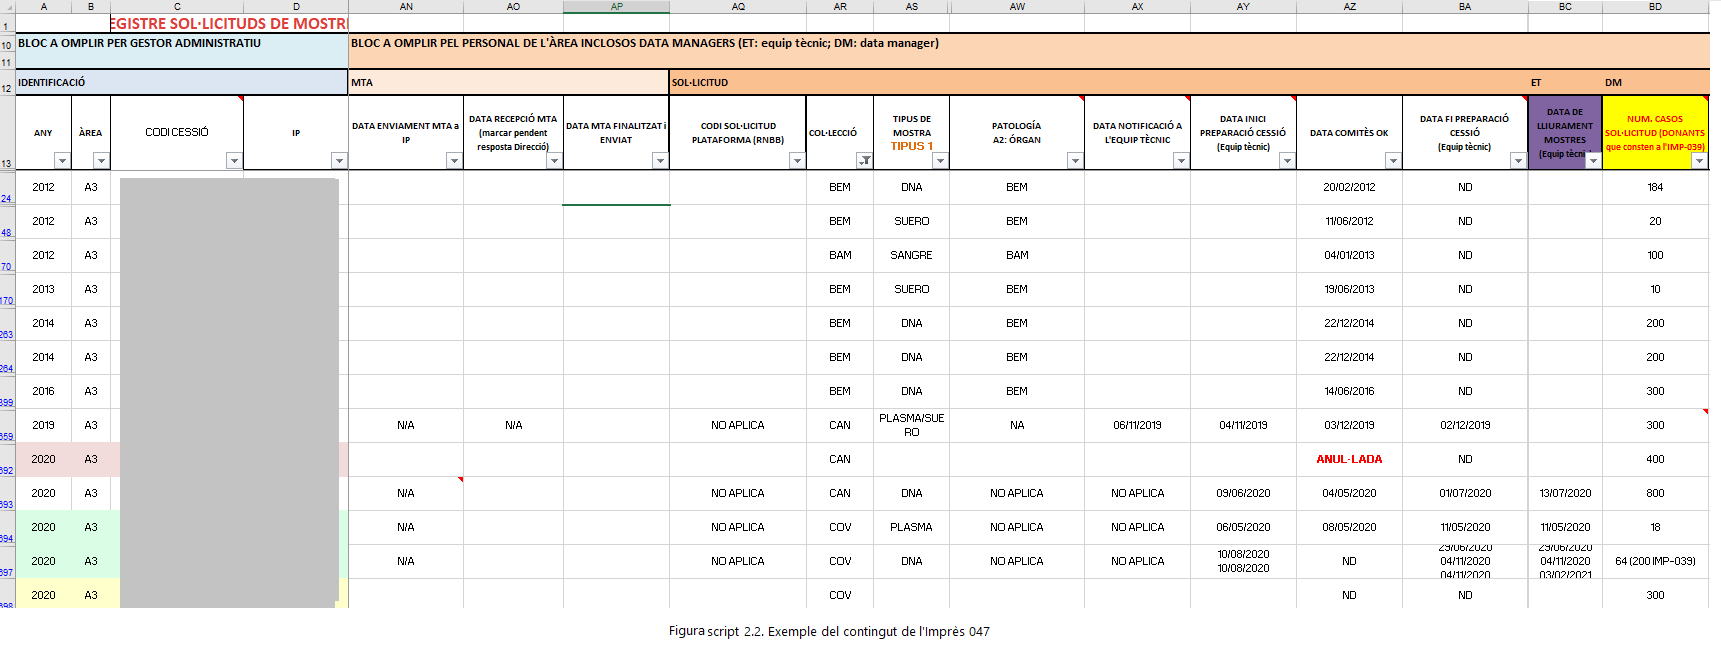

In [7]:
# Importem l'imprès. Aquest en concret, com té vàries pestanyes, seleccionem la que volem.
# A més, té 12 línies introductòries. Les treiem amb "header".
IMP047 = pd.read_excel("C:/Users/ferra/Downloads/IMP-047 rev 18 - Registre sol·licituds de mostres_2022.xls", 'SOL·LICITUDS DE MOSTRES', header=12)

# Visualitzem els 5 primers casos per comprovar que tot és correcte
# IMP047.head()

# 1) Seleccionem les variables que ens interessen i creem un dataframe (df) amb aquestes.
IMP047 = IMP047[['ANY','ÀREA','CODI CESSIÓ','COL·LECCIÓ','NUM. VIALS/FRAGMENTS CEDIDES']]

# 2) De totes les cessions, ens interessen únicament les de àrea 3 (A3), les filtrem.
# Cal tenir en compte que poden ser compartides amb altres àrees. Exemple: A2+A3. Per tant, ho farem amb el comandament "contains".
IMP047 = IMP047[IMP047["ÀREA"].str.contains("A3") == True]
# Filtrem també les que comprenen els anys de l'anàlisi (fins 2022)
IMP047 = IMP047[IMP047["ANY"] <= 2022]

# 3) Eliminem aquelles col·leccions que no són Fons Biobanc com a tal:
IMP047 = IMP047.drop(IMP047[IMP047['COL·LECCIÓ'] == "Colección de Anatomía Patológica"].index)
IMP047 = IMP047.drop(IMP047[IMP047['COL·LECCIÓ'] == "Diversos"].index)
IMP047 = IMP047.drop(IMP047[IMP047['COL·LECCIÓ'] == "Malalties Maternofetals"].index)

# 4) Treiem files amb anotacions (text) dins de la variable de recompte numèric, mitjançant el comandament "to_numeric":
IMP047 = IMP047[pd.to_numeric(IMP047['NUM. VIALS/FRAGMENTS CEDIDES'], errors='coerce').notnull()]

# 5) Creem una fila per cada col·lecció que té cessions de mostres compartida (per exemple: MET + DIAB).
# Aprofitem per canviar el nom als acrònims que calgui.

# COV I CTR
COV = IMP047[IMP047['COL·LECCIÓ']== "COV/CTR"] # Creem un dataframe amb la col·lecció de COV
COV['COL·LECCIÓ'] = COV['COL·LECCIÓ'].replace(['COV/CTR', 'COV']) # Repliquem els compartits, que seran COV
IMP047 = pd.concat([IMP047, COV]) # Juntem el dataframe que acabem de crear amb l'original
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(['COV/CTR', 'CTR']) # la resta dels repetits seran CTR

# MET I DIAB
MET = IMP047[IMP047['COL·LECCIÓ']== "MET - Di@bet.es"] # Creem un dataframe amb la col·lecció de MET
MET['COL·LECCIÓ'] = MET['COL·LECCIÓ'].replace(['MET - Di@bet.es', 'MET'])  # Repliquem els compartits, que seran MET
IMP047 = pd.concat([IMP047, MET]) # Juntem els dataframes
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(['MET - Di@bet.es', 'DIAB'])  # la resta dels repetits seran DIAB

# MET I CTR
MET2 = IMP047[IMP047['COL·LECCIÓ']== "MET - CTR"] # Creem un dataframe amb la col·lecció de MET
MET2['COL·LECCIÓ'] = MET2['COL·LECCIÓ'].replace(['MET - CTR', 'MET'])  # Repliquem els compartits, que seran MET
IMP047 = pd.concat([IMP047, MET2]) # Juntem els dataframes
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(['MET - CTR', 'CTR'])  # la resta dels repetits seran CTR

# CTR I MVH
MVH = IMP047[IMP047['COL·LECCIÓ']== "CTR, MVH"] # Creem un dataframe amb la col·lecció de MVH
MVH['COL·LECCIÓ'] = MVH['COL·LECCIÓ'].replace(['CTR, MVH', 'MVH']) # Repliquem els compartits, que seran MVH
IMP047 = pd.concat([IMP047, MVH]) # Juntem els dataframes
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(['CTR, MVH', 'CTR']) # la resta dels repetits seran CTR

# 6) Anomenem aquelles col·leccions que no estan anotades amb acrònims o mal anotades:
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(to_replace=['Diabetes'],value='DIAB')
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(to_replace=['Di@betes'],value='DIAB')
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(to_replace=['Di@bet.es'],value='DIAB')
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(to_replace=['CTL'],value='CTR')
IMP047['COL·LECCIÓ'] = IMP047['COL·LECCIÓ'].replace(to_replace=['CANONIC'],value='CAN')

# Casos a treure: AP, malalties maternofetals, ?, -, diversos...
# Anatomia patològica inclou mostres sòlides. Com en aquest document no podem distingir el tipus de mostres, les obviem.
# També treurem altres cessions que contenen mostres sòlides, així com les cessions d'on no es té informació sobre el nombre de mostres.
IMP047 = IMP047.loc[IMP047['COL·LECCIÓ'] != "Colección de Anatomía Patológica / OGP"]
IMP047 = IMP047.loc[IMP047['COL·LECCIÓ'] != "Colección de Anatomía Patológica"]
IMP047 = IMP047.loc[IMP047['COL·LECCIÓ'] != "Malalties Maternofetals"]
IMP047 = IMP047.loc[IMP047['COL·LECCIÓ'] != "Diversos"]
IMP047 = IMP047.loc[IMP047['COL·LECCIÓ'] != "-"]
IMP047 = IMP047.loc[IMP047['COL·LECCIÓ'] != "?"]

# Exemple visual del document (es tapa en gris la informació sensible (com els noms d'usuaris))
Image(filename='C:/Users/ferra/OneDrive/Escritorio/FIG22.png')

### <span style="color:yellowgreen"> 2.3. Pipeline de col·leccions</span> 

**2.3.1. DESCRIPCIÓ**

La "Pipeline de col·leccions" és un arxiu de tipus xls (Excel, full d'Excel), que resumeix el total de les dades registrades al LIMS per cada col·lecció del Fons Biobanc, així com el percentatge de dades ben anotades, per tal de dur-ne un registre prospectiu. Aquest registre es fa mitjançant consultes al sistema LIMS (NorayBanks) de forma semestral.
**Cada fila de l'Excel conté una col·lecció del Fons Biobanc.**

**2.3.2. VARIABLES NECESSÀRIES**

- **% donacions amb dades completes**: Variable de tipus percentatge. És el percentatge de donacions amb dades mínimes ben entrades a la base de dades per la col·lecció en qüestió.

- **% origen**: Variable de tipus percentatge. És el percentatge de donacions amb centre d'origen del donant (acostuma a ser l'hospital) ben entrat a la base de dades per la col·lecció en qüestió.

- **% edat**: Variable de tipus percentatge. És el percentatge de donants amb edat o data de naixement del/la donant entrades a la base de dades per la col·lecció en qüestió.

- **% sexe**: Variable de tipus percentatge. És el percentatge de donants amb sexe del/la donant entrats la base de dades per la col·lecció en qüestió.

- **% diagnòstic**: Variable de tipus percentatge. És el percentatge de donacions amb diagnòstic de la mostra entrat la base de dades per la col·lecció en qüestió.

- **% CI**: Variable de tipus percentatge. Percentatge de donacions amb consentiment informat del/la donant entrat la base de dades per la col·lecció en qüestió. Exemple: 20.33

**2.3.3. VARIABLES COMPLEMENTÀRIES**

En aquest document no hi ha variables que aportin informació addicional rellevant.

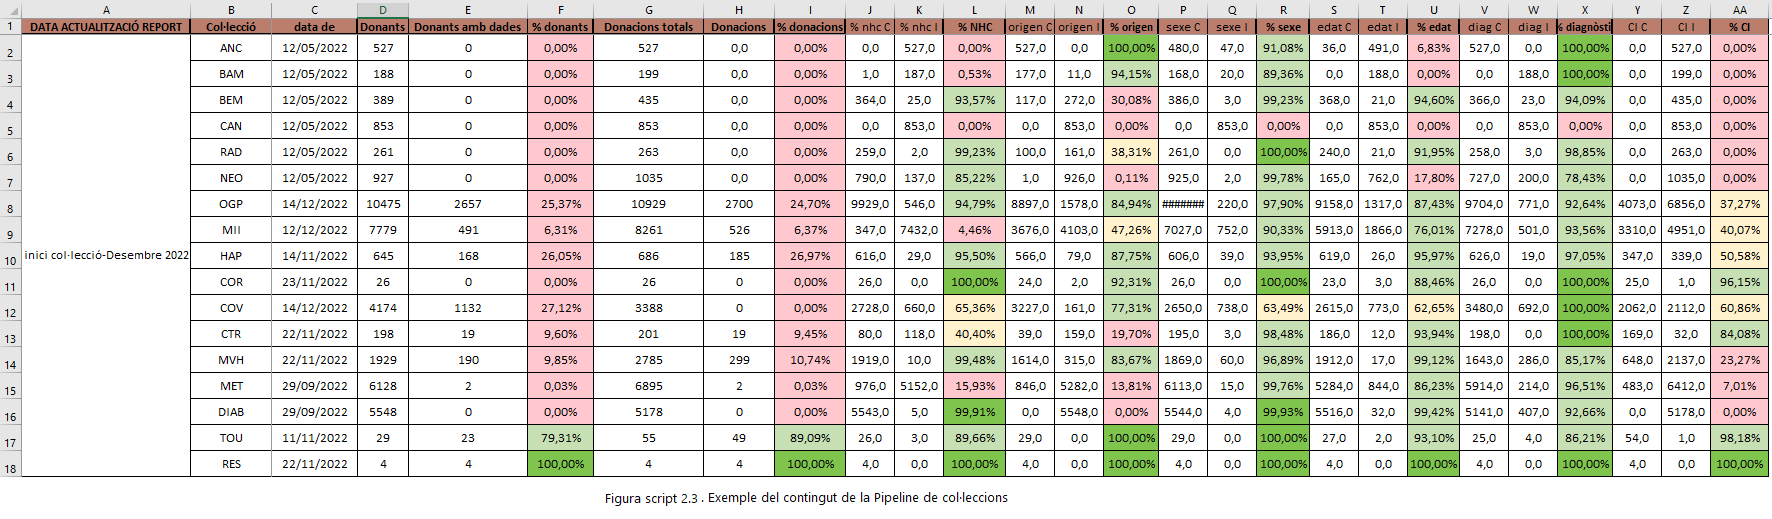

In [8]:
# Importem l'imprès. Aquest en concret, té vàries pestanyes, així que seleccionem la que volem:
PIPELINECOLS = pd.read_excel("C:/Users/ferra/Downloads/Pipeline Col·leccions (Juny-Desembre 2022).xlsx", 'REPORT GLOBAL', header=0)

# Visualitzem els 5 primers casos per comprovar que tot és correcte:
# PIPELINECOLS.head()

# 1) Seleccionem les variables que ens interessen i creem un dataframe (df) amb aquestes:
PIPELINECOLS = PIPELINECOLS[['Col·lecció','% donacions amb dades completes','% origen','% edat','% sexe','% diagnòstic','% CI']]

# 2) Arrodonim els percentatges amb dos decimals:
PIPELINECOLS = round(PIPELINECOLS, 2)

# Exemple visual del document
Image(filename='C:/Users/ferra/OneDrive/Escritorio/FIG23.png')

### <span style="color:lightcoral"> 2.4. IMP-419 - Registre consultes disponibilitat de mostres</span>

**2.4.1. DESCRIPCIÓ**

L'imprès 419 és un arxiu de tipus xls (Excel, full d'Excel), que anota les consultes d'organismes externs per sol·licitar mostres, algunes de les quals esdevindran cessions. **Cada fila de l'Excel conté una consulta de mostres diferent**.

**2.4.2. VARIABLES NECESSÀRIES**

- **DATA RECEPCIÓ CONSULTA**: Variable de tipus data. Anota la data a la qual s'ha rebut la consulta per part de la persona que ho sol·licita.

- **ÀREA**: Variable de camp de text. Anota l'àrea del Biobanc que gestionava cada sol·licitud. En el nostre cas, per aquest projecte, ens interessarà l'àrea 3 (A3).

- **DISPONIBILITAT DE LES MOSTRES (sí/no)**: Variable de camp de text. Registra si es tenia disponibilitat de les mostres per part del Biobanc per tal de realitzar la cessió (de vegades es sol·liciten tipus de mostra que el Biobanc no disposa, o un nombre molt gran de casos, respecte als que es tenen disponibles).

- **LA CONSULTA HA ESDEVINGUT UNA CESSIÓ O UN SERVEI?**: Variable de camp de text. Anota si es la consulta ha esdevingut una cessió. Llavors, s'afegiria a l'IMP-047.

- **Col·leccions FBB**: Variable de camp de text. Anota el nom de la col·lecció de Fons Biobanc que conté les mostres per cada consulta.

- **OBSERVACIONS (Si no s'han pogut cedir mostres, indicar motiu)**: Variable de camp de text. Registra un comentari amb els tipus de mostra demanats i si s'ha acceptat o no la consulta com a cessió (amb especificacions). Un exemple seria: "Demanen disponibilitat de FFPE tumorals parellats amb plasma i PBMCs. Se'ls hi diu que no hi hauria la possibilitat de PBMCs. Tornem a contactar a principis de maig però sense resposta."

**2.4.3. VARIABLES COMPLEMENTÀRIES**

En aquest document no hi ha variables que aportin informació addicional rellevant.

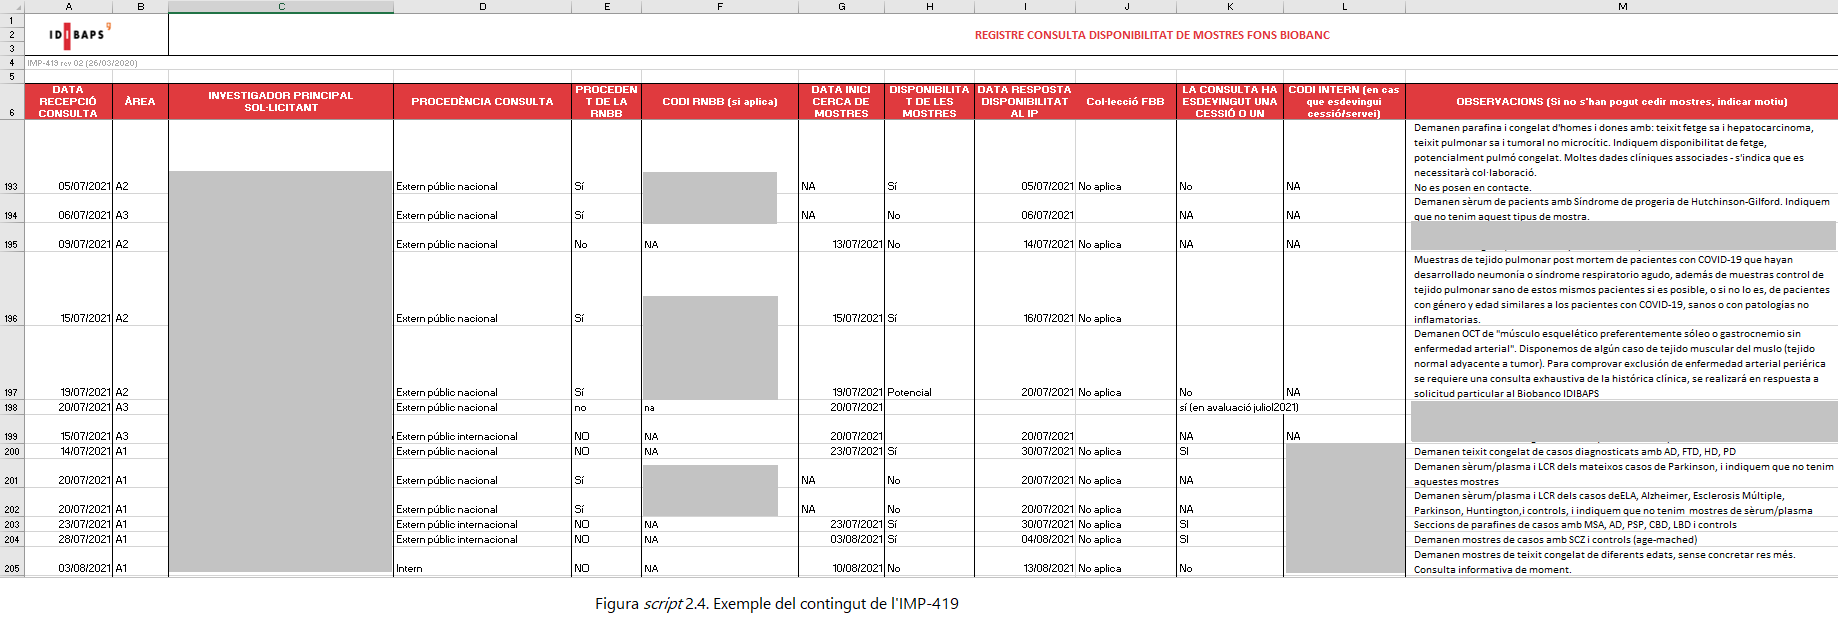

In [9]:
# Importem l'imprès. Aquest en concret, té 5 línies de logo d'IDIBAPS i introducció del document, les treiem amb "header":
IMP419 = pd.read_excel("C:/Users/ferra/Downloads/IMP-419 rev 02.01 - Registre consultes disponibilitat de mostres 2023.xlsx", header=5)

# Visualitzem els 5 primers casos per comprovar que tot és correcte:
# IMP419.head()

# 1) Seleccionem les variables que ens interessen i creem un dataframe (df) amb elles:
IMP419 = IMP419[['DATA RECEPCIÓ CONSULTA','ÀREA','DISPONIBILITAT DE LES MOSTRES (sí/no)',"LA CONSULTA HA ESDEVINGUT UNA CESSIÓ O UN SERVEI?",'Col·leccions FBB',"OBSERVACIONS (Si no s'han pogut cedir mostres, indicar motiu)"]]

# 2) De totes les cessions, ens interessen únicament les de àrea 3 (A3), les filtrem.
# Cal tenir en compte que poden ser compartides amb altres àrees (Exemple: A2+A3). Ho monitoritzem amb el comandament "contains".
IMP419 = IMP419[IMP419["ÀREA"].str.contains("A3") == True]

# 3) Com aquest document ha estat modificat per un gran nombre de persones, els camps de text estan desordenats i no unificats.
# Visualitzarem l'imprès i mirarem quines respostes anòmales hi ha.
# IMP419

# 4) Seguidament, unificarem les respostes de les variables dicotòmiques en "Sí" o "No", substituint les anòmales:
IMP419['DISPONIBILITAT DE LES MOSTRES (sí/no)'] = IMP419['DISPONIBILITAT DE LES MOSTRES (sí/no)'].replace(
    'no', 'No').replace(
    'NO','No').replace(
    'no (A3); pendent A1', 'No').replace(
    'Pendent','No').replace(
    'na','No').replace(
    'Parcial','Sí').replace(
    'Parcial (limitació dades)', 'Sí').replace(
    'Sí (parcial)','Sí').replace(
    'Sí (limitació dades)','Sí').replace('Potencial','Sí')
IMP419['LA CONSULTA HA ESDEVINGUT UNA CESSIÓ O UN SERVEI?'] = IMP419['LA CONSULTA HA ESDEVINGUT UNA CESSIÓ O UN SERVEI?'].replace(
    'NA','NA').replace(
    'No progressa (Octubre 2022)','No').replace(
    'Pendent (05/08/21)','No').replace(
    'no','No').replace(
    'sí','Sí').replace(
    'enviat IMP-039','Sí').replace(
    'sí (en avaluació juliol2021)','Sí').replace(
    'sí (en avaluació juliol2021)','Sí')

# Exemple visual del document (es tapa en gris la informació sensible (com els noms d'usuaris))
Image(filename='C:/Users/ferra/OneDrive/Escritorio/FIG24.png')

### <span style="color:gold"> 2.5. Excel d'enviaments (ENVIAMENTS)</span>

**2.5.1. DESCRIPCIÓ**

L'Access d'enviaments (o Acces de moviments) és una base de dades que anota els moviments que es fan a cada caixa que entra o surt dels congeladors o tancs de nitrogen del biobanc. L'exportació de les seves dades és aquest document de tipus xls (Excel, full d'Excel). **Cada fila és un moviment** (entrada o sortida de mostres per petició del grup usuari).


**2.5.2. VARIABLES NECESSÀRIES**

- **DATA**: Variable de tipus data. Dia, mes i any del moviment en qüestió.

- **ENTRADA**: Variable dicotòmica (True/False). Anota si ha hagut una entrada de mostres en aquest moviment amb "True". 

- **SORTIDA**: Variable dicotòmica (True/False). Anota si ha hagut una sortida de mostres en aquest moviment amb "True". 

- **PROJECTE**: Variable de camp de text. Codificació alfa-numèrica del grup usuari responsable del moviment. Com conté els noms dels IPs responsables (caps dels grups usuaris) per les línies d'investigació, els pseudonimitzarem. 

**2.5.3. VARIABLES COMPLEMENTÀRIES**

- **TEMPS DEDICAT**: Variable de desplegable. Registra el temps que el/la tècnic de criopreservació ha invertit per la gestió del moviment (fins a 8 min, de 8 a 10 min, de 10 a 20 min o més de 20 min). **Justificació:** Desde Direcció es demana tenir un registre del temps que es dedica a cada moviment per tal d'optimitzar el temps dels moviments.

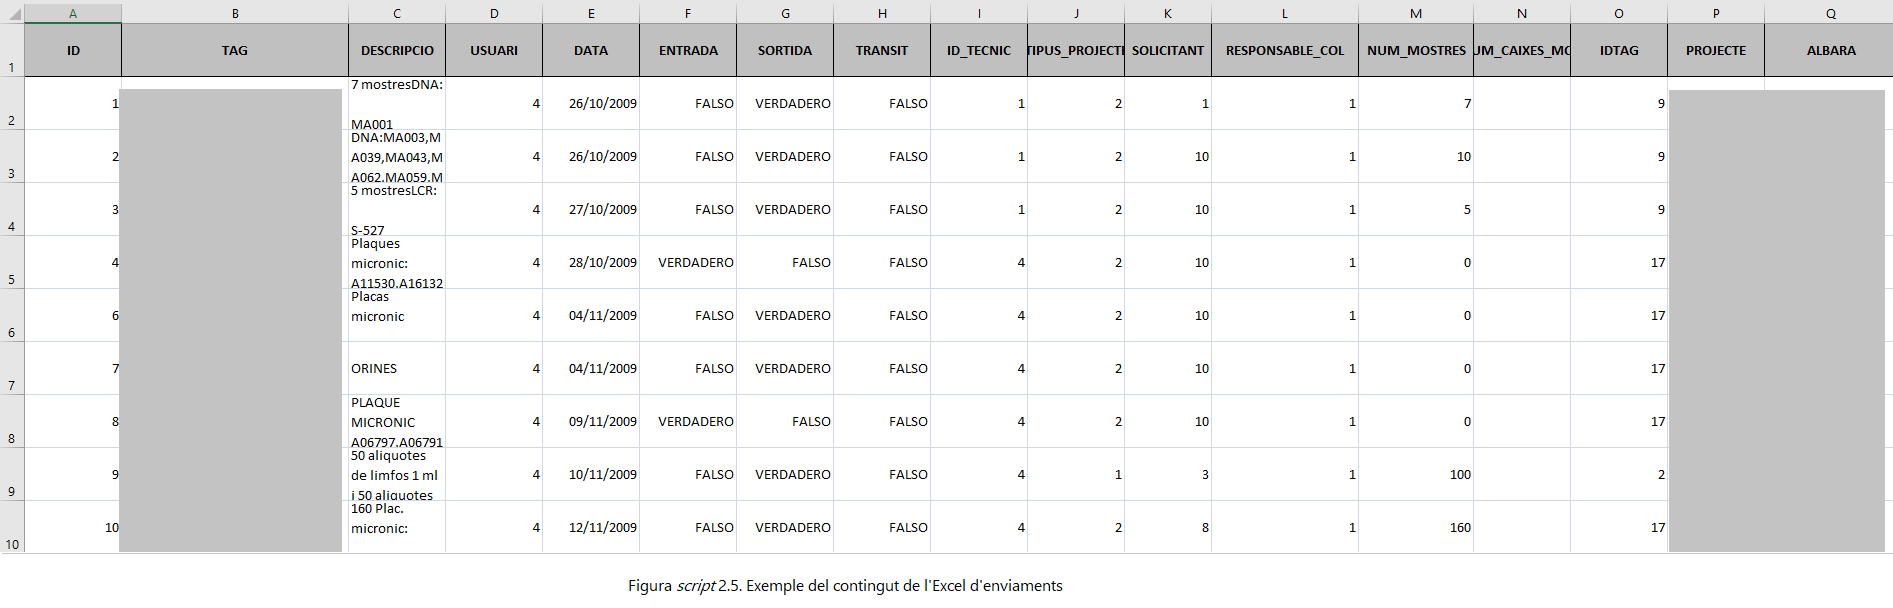

In [10]:
# Importem la exportació de l'Access de moviments:
ENVIAMENTS = pd.read_excel("C:/Users/ferra/Downloads/ENVIAMENTS.xlsx")

# Visualitzem els 5 primers casos per comprovar que tot és correcte:
# ENVIAMENTS.head()

# 1) Seleccionem les variables que ens interessen. Creem un dataframe (df) amb aquestes:
ENVIAMENTS = ENVIAMENTS[['DATA','ENTRADA','SORTIDA','PROJECTE','TEMPS DEDICAT']]

# 2) Pseudonimització
# Buscarem els codis pseudonimitzats de cada línia d'investigació a un full de dades (és un Excel extern).
LIA0_ANON = pd.read_excel("C:/Users/ferra/Downloads/serveis a3 a0 anon.xlsx",'A0', header=0)
# Juntem els noms de les línies d'investigació al dataframe original amb el dels codis de pseudonimització.
ENVIAMENTS['Línia A0'] = ENVIAMENTS['PROJECTE']
ENVIAMENTS = pd.merge(ENVIAMENTS, LIA0_ANON, on="Línia A0", how = "outer")
# Treiem els casos no inclosos a l'Excel d'enviaments.
# Seran Na per la variable obligatòria "ENTRADA", és a dir, mai haurà entrat una mostra per el Servei (A0)
ENVIAMENTS = ENVIAMENTS.dropna(subset = ['ENTRADA'])

# 3) Hi ha moviments que no s'han anotat correctament i no compten com a ENTRADA ni com a SORTIDA. 
# Els treiem (és a dir, eliminem els enviaments que siguin tant False per ENTRADA com per SORTIDA)
ENVIAMENTS = ENVIAMENTS.loc[~((ENVIAMENTS['ENTRADA'] == False)  & (ENVIAMENTS['SORTIDA'] == False))]

# Exemple visual del document (es tapa en gris la informació sensible (com els noms d'usuaris))
Image(filename='C:/Users/ferra/OneDrive/Escritorio/FIG25.png')

### <span style="color:violet"> Excel de magatzem (FMULTIPLE)</span> 

**DESCRIPCIÓ** 

Consisteix en l'exportació en format xls (Excel, full d'Excel) de l'Access de congeladors/magatzem. Aquesta és una base de dades que anota les ubicacions de cada caixa amb la informació del grup usuari del qual prové. **Cada fila és una capsa que conté mostres**.

**VARIABLES NECESSÀRIES**

Aquest document té diferents pestanyes amb variables necessàries.

- **SERVEI**: Variable de tipus camp de text. Nom del grup usuari. Per tal de pseudonimitzar els grups usuaris, s'utilitzaran aquests les codificacions (SA0-número) creades en un full de dades extern.

- **% PONDERAT CONGELADORS**: Variable numèrica de tipus percentatge. Anota el percentatge d'ocupació de cada capsa respecte el total general de congeladors, ponderat segons la capacitat de la capsa (una capsa més gran tindrà una ponderació més gran que una de petita).

- **% OCUPACIÓ NL**: Variable numèrica de tipus percentatge. Anota el percentatge d'ocupació de cada capsa respecte el total general de tancs de nitrogen líquid, ponderat segons la capacitat de la capsa.

**VARIABLES COMPLEMENTÀRIES**

- **ENTRADA**: Variable de tipus data. És la data (dia/mes/any) d'entrada de la capsa al Biobanc. **Justificació:** Es pot utilitzar aquesta variable per a tenir referències a nivell temporal de les entrades de caixes. D'aquesta manera es pot arribar a comparar si hi ha grups usuaris que tenen moltes entrades de capses en un periode determinat.

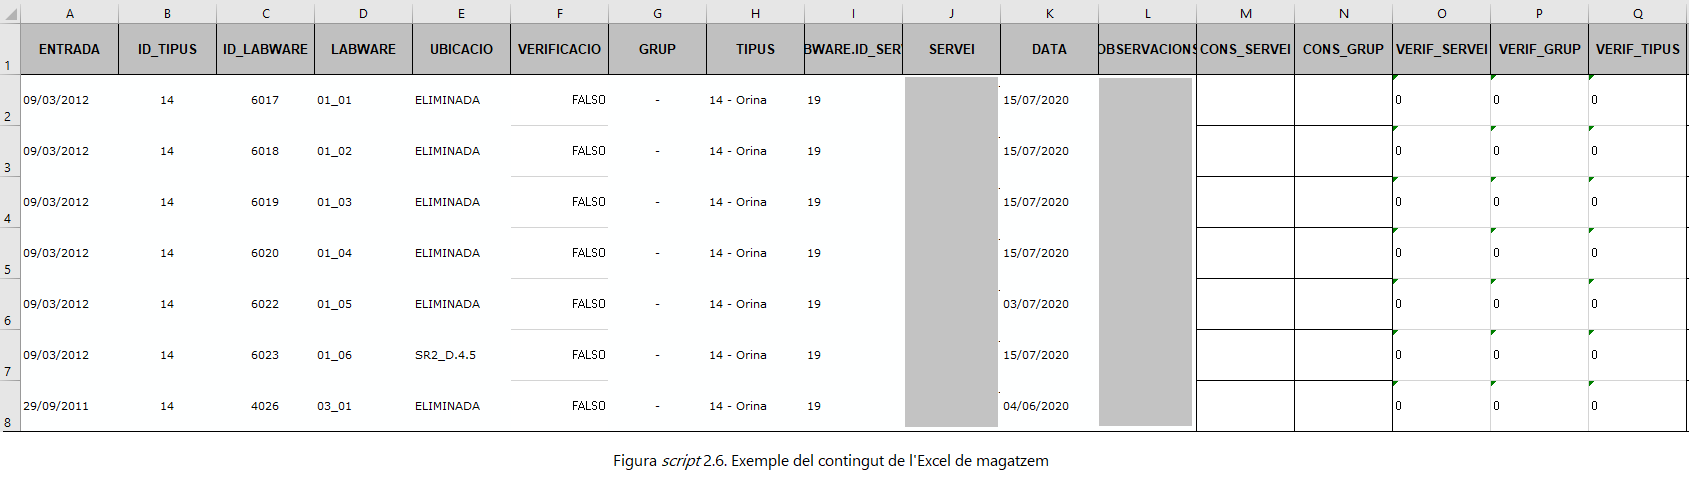

In [11]:
# Importem la exportació de l'Access de congeladors/magatzem:
FMULTIPLE = pd.read_excel("C:/Users/ferra/Downloads/FMULTIPLE.xlsx", 'FMULTIPLE')

# 1) Seleccionem les variables que ens interessen, més algunes addicionals (degut a que hem de treure capses que no han de sortir a l'anàlisi).
# Creem un dataframe (df) amb totes:
FMULTIPLE = FMULTIPLE[['SERVEI','ENTRADA','UBICACIO']]

# 2) Treiem capses que no ens interessen
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "ELIMINADA"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "IP"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "RECUPERADA PER IP"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "PENDENT INVENTARI"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "Congelador -20ºC"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "Congelador -20ºC aDNA"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "Nevera 4ºC aDNA"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "Nevera 4ºC Cultius"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "Primer Envío MATER"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "EN TRÀNSIT PER CESSIÓ"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "TRÀNSIT"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['UBICACIO'] == "Mostres reubicades a microplaca nova."].index)

# 3) Treiem el contingut de les neveres i el congelador back-up (no entraria a l'anàlisi)
FMULTIPLE['Congelador/Tanc'] = FMULTIPLE['UBICACIO'].apply(lambda x: x.split('_')[0])
# Abans dels recomptes, juntem els refrigeradors (Congeladors/Tancs) SR1 amb SE1 (per temes interns han de comptar-se junts).
FMULTIPLE['Congelador/Tanc'] = FMULTIPLE['Congelador/Tanc'].replace(to_replace=['SR1','SE1'],value='SR1+SE1')
# Treiem neveres i back-up.
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['Congelador/Tanc'] == "NE1"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['Congelador/Tanc'] == "NE2"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['Congelador/Tanc'] == "NE3"].index)
FMULTIPLE = FMULTIPLE.drop(FMULTIPLE[FMULTIPLE['Congelador/Tanc'] == "LOG06"].index)

# 4) Pseudonimització
# Creem una columna amb els noms de les línies d'investigació pseudonimitzades.
# La pseudonimització es farà adjudicant un codi de tipus "SA0-número" a cada línia d'investigació A0, en un full de dades extern.
FMULTIPLE['Línia A0'] = FMULTIPLE['SERVEI']
LIA0_ANON = pd.read_excel("C:/Users/ferra/Downloads/serveis a3 a0 anon.xlsx",'A0', header=0)
# Juntem els noms dels serveis al dataframe original amb el dels codis de pseudonimització.
FMULTIPLE = pd.merge(FMULTIPLE, LIA0_ANON, on="Línia A0")

# Visualitzem els 5 últims casos per comprovar que tot és correcte:
# FMULTIPLE.tail()

# Exemple visual del document (es tapa en gris la informació sensible (com els noms d'usuaris))
Image(filename='C:/Users/ferra/OneDrive/Escritorio/FIG26.png')

In [12]:
# Per al càlcul de la variable 10, haurem de comparar el nombre de capses en dos temps determinats.
# En aquest cas, agafarem com a comparatiu la mateixa exportació de dades, però amb data posterior (31/01/2023).
# Fem el mateix processament que amb l'anterior dataframe.
# 1) Creem el df
FMULTIPLE2 = pd.read_excel("C:/Users/ferra/Downloads/FMULTIPLE 31012023.xlsx", 'FMULTIPLE')
FMULTIPLE2 = FMULTIPLE2[['SERVEI','ENTRADA','UBICACIO']]
# 2) Treiem capses que no ens interessen
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "ELIMINADA"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "IP"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "RECUPERADA PER IP"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "PENDENT INVENTARI"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "Congelador -20ºC"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "Congelador -20ºC aDNA"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "Nevera 4ºC aDNA"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "Nevera 4ºC Cultius"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "Primer Envío MATER"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "EN TRÀNSIT PER CESSIÓ"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "TRÀNSIT"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['UBICACIO'] == "Mostres reubicades a microplaca nova."].index)
# 3) Treiem el contingut de les neveres i el congelador back-up (no entraria a l'anàlisi)
FMULTIPLE2['Congelador/Tanc'] = FMULTIPLE2['UBICACIO'].apply(lambda x: x.split('_')[0])
# Juntem els refrigeradors (Congeladors/Tancs) SR1 amb SE1 (per temes interns han de comptar-se junts).
FMULTIPLE2['Congelador/Tanc'] = FMULTIPLE2['Congelador/Tanc'].replace(to_replace=['SR1','SE1'],value='SR1+SE1')
# Treiem neveres i back-up.
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['Congelador/Tanc'] == "NE1"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['Congelador/Tanc'] == "NE2"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['Congelador/Tanc'] == "NE3"].index)
FMULTIPLE2 = FMULTIPLE2.drop(FMULTIPLE2[FMULTIPLE2['Congelador/Tanc'] == "LOG06"].index)
# 4) Pseudonimització
FMULTIPLE2['Línia A0'] = FMULTIPLE2['SERVEI']
LIA0_ANON = pd.read_excel("C:/Users/ferra/Downloads/serveis a3 a0 anon.xlsx",'A0', header=0)

# Juntem els noms dels serveis al dataframe original amb el dels codis de pseudonimització.
FMULTIPLE2 = pd.merge(FMULTIPLE2, LIA0_ANON, on="Línia A0")

## 3. ANÀLISI PRELIMINAR


A continuació, **es representaran algunes de les variables escollides** per afegir informació que pugui ser útil per a futurs anàlisis i per donar una idea global del comportament dels grups usuaris.

In [13]:
# Anotem la data de l'anàlisi en format europeu.
#data = date.today()

# Per aquesta primera anàlisi es prendrà la data del 31/12/2022:
data = date(2022, 12, 31)
data = data.strftime("%d/%m/%Y")
print("Anàlisi realitzat en data:", data)

Anàlisi realitzat en data: 31/12/2022


### 3.1. Número d'alíquotes (per col·leccions de FBB i línia investigació A0 associada a A3 (LIA3)

In [14]:
# FONS BIOBANC
# Ordenem el df per emfatitzar les col·leccions amb més i menys mostres.
ANALISICOLS_FBB2 = ANALISICOLS_FBB.sort_values(by="TOTAL")

# El total de col·leccions disponibles serà igual a l'abarcament del dataframe (nombre de files del df).
print("Hi ha un total de", len(ANALISICOLS_FBB2),"col·leccions de Fons Biobanc avaluables.")

# El total de mostres disponibles serà la suma dels totals per cada col·lecció.
print("El Biobanc té un total de",sum(ANALISICOLS_FBB2['TOTAL']),"mostres disponibles de col·leccions de Fons Biobanc avaluables.")
# Com tenim les dades ordenades de menor a major, podem cridar les col·leccions amb els índexs (-1 per la última fila i 0 per la primera) i els valors amb màxims i mínims.
print("- La col·lecció de Fons Biobanc avaluable amb més mostres és",ANALISICOLS_FBB2['Col·lecció'].iloc[-1],"amb",max(ANALISICOLS_FBB2['TOTAL']),"mostres disponibles.")
print("- La col·lecció de Fons Biobanc avaluable amb menys mostres és",ANALISICOLS_FBB2['Col·lecció'].iloc[0],"amb",min(ANALISICOLS_FBB2['TOTAL']),"mostres disponibles.")

# LIA3
# Repetim el procés per les LIA3.
ANALISICOLS_LIA3_2 = ANALISICOLS_LIA3.sort_values(by="TOTAL")
print("Hi ha un total de", len(ANALISICOLS_LIA3_2),"línies d'investigació LIA3 avaluables.")
print("El Biobanc té un total de",sum(ANALISICOLS_LIA3_2['TOTAL']),"mostres disponibles de LIA3 avaluables.")
print("- La línia d'investigació A0 associada a A3 (LIA3) avaluable amb més mostres és",ANALISICOLS_LIA3_2['Línia A3 (anon)'].iloc[-1],"amb",max(ANALISICOLS_LIA3_2['TOTAL']),"mostres disponibles.")
print("- La línia d'investigació A0 associada a A3 (LIA3) avaluable amb menys mostres és",ANALISICOLS_LIA3_2['Línia A3 (anon)'].iloc[0],"amb",min(ANALISICOLS_LIA3_2['TOTAL']),"mostres disponibles.")

Hi ha un total de 17 col·leccions de Fons Biobanc avaluables.
El Biobanc té un total de 623340 mostres disponibles de col·leccions de Fons Biobanc avaluables.
- La col·lecció de Fons Biobanc avaluable amb més mostres és MET amb 196868 mostres disponibles.
- La col·lecció de Fons Biobanc avaluable amb menys mostres és RES amb 69 mostres disponibles.
Hi ha un total de 12 línies d'investigació LIA3 avaluables.
El Biobanc té un total de 133680 mostres disponibles de LIA3 avaluables.
- La línia d'investigació A0 associada a A3 (LIA3) avaluable amb més mostres és LIA3-9 amb 91537 mostres disponibles.
- La línia d'investigació A0 associada a A3 (LIA3) avaluable amb menys mostres és LIA3-7 amb 0 mostres disponibles.


### 3.2. Cessions de mostres (per col·leccions de FBB)

In [15]:
# El total de sol·licituds serà el total de línies del df.
print("Hi ha un total de",len(IMP047),'sol·licituds de mostres (A3) al Biobanc desde',min(IMP047['ANY']),'fins al',max(IMP047['ANY']),'.')

Hi ha un total de 202 sol·licituds de mostres (A3) al Biobanc desde 2012.0 fins al 2022.0 .


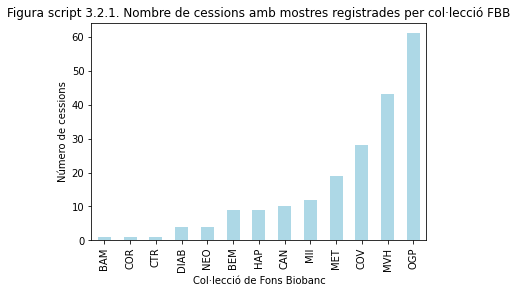

In [17]:
# 1) RECOMPTE DE CESSIONS PER COl·LECCIÓ
# Descartem columnes no desitjades per el recompte.
IMP047_CESSIONS = IMP047.drop(['ANY','ÀREA','NUM. VIALS/FRAGMENTS CEDIDES'], axis=1)
# Amb una sola columna per analitzar (CODI CESSIÓ), agrupem per COL·LECCIÓ i sumem les mostres. 
IMP047_CESSIONS = IMP047_CESSIONS.groupby(['COL·LECCIÓ']).count()
# Reordenem ascendentment.
IMP047_CESSIONS = IMP047_CESSIONS.sort_values(by=['CODI CESSIÓ'], ascending=True)

# Fem el bar plot, canviant de color.
IMP047_CESSIONS.plot.bar(color="lightblue", title="Figura script 3.2.1. Nombre de cessions amb mostres registrades per col·lecció FBB")
plt.ylabel("Número de cessions")
plt.xlabel("Col·lecció de Fons Biobanc")
# Treiem la llegenda (degut a que ja està inclosa a l'eix x)
plt.legend('', frameon=False)

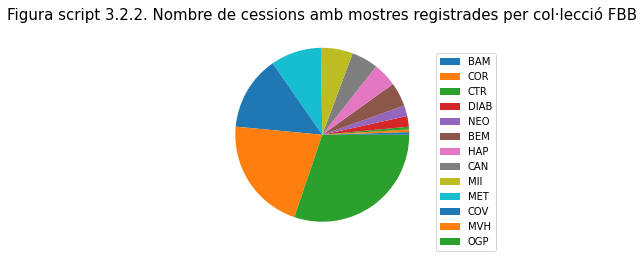

In [18]:
# En pie plot:
IMP047_CESSIONS.plot.pie(subplots=True,labeldistance=None)
plt.title('Figura script 3.2.2. Nombre de cessions amb mostres registrades per col·lecció FBB', fontsize=15)
plt.xlabel('', fontsize=11)
plt.ylabel('',fontsize=11)
plt.legend( bbox_to_anchor=(1,0.9))
plt.show()

### 3.3. Anàlisi de magatzem (script de magatzem)

In [19]:
# Importarem els resultats de l'anàlisi de magatzem a nivell d'ocupació de congeladors i tancs de nitrogen.
# Aquests documents ens donaran un context de l'ocupació de cada col·lecció i línia d'investigació (LIA3 o LIA0).
SUMA_FBB_A3_A0_80ºC = pd.read_excel("C:/Users/ferra/Downloads/FBB_A3_A0_80ºC.xlsx")
SUMA_FBB_A3_A0_TN = pd.read_excel("C:/Users/ferra/Downloads/FBB_A3_A0_TN.xlsx")

# Aquests dataframes els veurem als resultats del TFM per no sobrecarregar l'script.

## 4. ANÀLISI DE SELECCIÓ DE VARIABLES

Un cop ubicat el context general de les dades i l'objectiu, procedirem a calcular els valors per a cada variable necessària i realitzar així el model d'agrupament de cada grup usuari.

Addicionalment, establirem els llindars màxims que supera i anotarem l'agrupament que té (Actiu PRO, Actiu o Inactiu) per a cada variable. Així, en tindrem un seguiment amb el què podrem determinar què és el que ha de millorar cada usuari per tal de canviar de grup. Per exemple, pot haver un grup usuari que entri dins del llindar d'"Actiu PRO" gràcies a que compleix les condicions per tres variables, però sigui "Inactiu" per l'influència d'una altra variable, sent finalment "Inactiu". Tenint aquest seguiment podem informar a cada grup usuari que, si vol pertànyer al grup "Actiu PRO", haurà de millorar en l'apartat que correspon a la última variable.

### 4.1. GRUPS USUARIS DEL FONS BIOBANC

#### 4.1.1. VARIABLES 1 I 2 (FONS BIOBANC)

**Definició** (1) Mou el 15% del total d’alíquotes en cessions de mostres (Actiu PRO), 10%-15% del total d’alíquotes (Actiu) o menys del 10% (Inactiu).

(2) En cas d’incompliment, assoleix >25% de reducció del magatzem mitjançant neteja (Actiu PRO) o 25-20% (Actiu). Aquesta segona especificació es farà un cop els usuaris hagin estat assabentats de la nova política de criopreservació i vulguin realitzar neteja al magatzem.

**Necessitem:**

**Variable 1**: Percentatge d'alíquotes cedides (per investigació)

**Variable 2**: Percentatge de reducció del magatzem en un temps determinat (no s’aplica per aquest primer anàlisi)

In [20]:
# VARIABLE 1: PERCENTATGE D'ALÍQUOTES CEDIDES

# Per analitzar el percentatge d'alíquotes en cessions de mostres, buscarem el total de mostres cedides per col·lecció.
# Treiem les variables que no ens interessen.
IMP047_MOSTRES = IMP047.drop(['ANY', 'ÀREA','CODI CESSIÓ'], axis=1)
# Realitzem la suma de l'agrupament de totes les cessions per col·lecció.
IMP047_MOSTRES = IMP047_MOSTRES .groupby(['COL·LECCIÓ']).sum()
# Ens queden els vials/mostres cedides.

In [21]:
# El total d'alíquotes per col·lecció el tenim al dataframe "ANALISISCOLS_FBB" creat anteriorment.
# Canviem el nom de la columna perquè sigui el mateix que el del dataframe anterior.
ANALISICOLS_FBB = ANALISICOLS_FBB.rename(columns={"Col·lecció": "COL·LECCIÓ"})
# I anotem la primera columna com a índex per poder operar conjuntament.
ANALISICOLS_FBB = ANALISICOLS_FBB.set_index(['COL·LECCIÓ'])

In [22]:
# Per tant, podem calcular el percentatge juntant els dos dataframes i operant amb les variables.
MERGE_FBB = ANALISICOLS_FBB.merge(IMP047_MOSTRES, how="outer", left_index=True, right_index=True)
# Treiem col·leccions que tinguin NaN per alguna de les variables.
MERGE_FBB = MERGE_FBB.replace(np.nan,0) 
# Finalment, calculem la variable 1:
# El percentatge d'alíquotes cedides serà el número d'alíquotes cedides entre el total, per cada col·lecció de Fons Biobanc.
MERGE_FBB['Variable 1: % mostres cedides'] = MERGE_FBB['NUM. VIALS/FRAGMENTS CEDIDES']/MERGE_FBB['TOTAL']*100
# Arrodonim a dos decimals:
MERGE_FBB['Variable 1: % mostres cedides'] = round(MERGE_FBB['Variable 1: % mostres cedides'], 2)
MERGE_FBB

,TOTAL,NUM. VIALS/FRAGMENTS CEDIDES,Variable 1: % mostres cedides
COL·LECCIÓ,,,
ANC,1113,0.0,0.00
BAM,962,100.0,10.40
BEM,8675,1844.0,21.26
CAN,3513,3473.0,98.86
COR,193,99.0,51.30
COV,48999,4527.0,9.24
CTR,4440,15.0,0.34
DIAB,26404,16083.0,60.91
HAP,13614,747.0,5.49


In [23]:
# Creem una llista per a cada tipus de grup (Actiu PRO, Actiu, Inactiu)
llindar_1_actiupro = []
llindar_1_actiu = []
llindar_1_inactiu = []

# Cada grup l'anotarem també al mateix dataframe, en una nova columna (que de moment estarà buida):
MERGE_FBB['Variable 1: Grup'] = " "

# Treiem els índex per poder iterar en el dataframe:
MERGE_FBB = MERGE_FBB.reset_index()
# Per cada col·lecció al dataframe, dividirem segons els llindars establerts.
# El condicional serà: si té 15% o més de mostres cedides, serà Actiu PRO.
# Si té 10% o menys, serà Inactiu.
# La resta, pertanyerà al grup Actiu.
for i in range(len(MERGE_FBB)):
    if MERGE_FBB['Variable 1: % mostres cedides'].iloc[i] >= 15:
        llindar_1_actiupro.append(MERGE_FBB['COL·LECCIÓ'].iloc[i])
        MERGE_FBB['Variable 1: Grup'].iloc[i] = "Actiu PRO"
    elif MERGE_FBB['Variable 1: % mostres cedides'].iloc[i] <= 10:
        llindar_1_inactiu.append(MERGE_FBB['COL·LECCIÓ'].iloc[i])
        MERGE_FBB['Variable 1: Grup'].iloc[i] = "Inactiu"
    else:
        llindar_1_actiu.append(MERGE_FBB['COL·LECCIÓ'].iloc[i])
        MERGE_FBB['Variable 1: Grup'].iloc[i] = "Actiu"

        
# Finalment, extraiem la informació d'interès (variable i grup calculat per aquesta):
FBB_VARIABLE1 = MERGE_FBB[['COL·LECCIÓ','Variable 1: % mostres cedides','Variable 1: Grup']]
# Canviem el nom de la primera columna perquè concordi amb la resta de variables a continuació:
FBB_VARIABLE1.rename(columns = {'COL·LECCIÓ':'Col·lecció'}, inplace = True)

print("De les col·leccions disponibles (", len(ANALISICOLS_FBB) ,") tenim informació suficient per fer l'anàlisi de cessions de (", len(MERGE_FBB) ,").")
print('LLINDAR 1 - ACTIU PRO: Les col·leccions de Fons Biobanc amb 15% o més de mostres cedides són:', llindar_1_actiupro)    
print('LLINDAR 1 - ACTIU: Les col·leccions de Fons Biobanc entre 10 i 15% mostres cedides són:', llindar_1_actiu)  
print('LLINDAR 1 - INACTIU: Les col·leccions de Fons Biobanc amb menys de 10% de mostres cedides són:', llindar_1_inactiu)  

De les col·leccions disponibles ( 17 ) tenim informació suficient per fer l'anàlisi de cessions de ( 17 ).
LLINDAR 1 - ACTIU PRO: Les col·leccions de Fons Biobanc amb 15% o més de mostres cedides són: ['BEM', 'CAN', 'COR', 'DIAB', 'NEO', 'OGP']
LLINDAR 1 - ACTIU: Les col·leccions de Fons Biobanc entre 10 i 15% mostres cedides són: ['BAM', 'MII']
LLINDAR 1 - INACTIU: Les col·leccions de Fons Biobanc amb menys de 10% de mostres cedides són: ['ANC', 'COV', 'CTR', 'HAP', 'MET', 'MVH', 'RAD', 'RES', 'TOU']


In [24]:
FBB_VARIABLE1

,Col·lecció,Variable 1: % mostres cedides,Variable 1: Grup
0,ANC,0.00,Inactiu
1,BAM,10.40,Actiu
2,BEM,21.26,Actiu PRO
3,CAN,98.86,Actiu PRO
4,COR,51.30,Actiu PRO
5,COV,9.24,Inactiu
6,CTR,0.34,Inactiu
7,DIAB,60.91,Actiu PRO
8,HAP,5.49,Inactiu
9,MET,3.34,Inactiu


In [25]:
# VARIABLE 2: PERCENTATGE DE REDUCCIÓ DE MAGATZEM EN UN TEMPS DETERMINAT

# Pel que fa a la reducció de magatzem, com s'ha esmentat anteriorment, no es calcularà per la primera posada a punt del model.
# Això es deu a que la reducció d'espai de magatzem es tindrà en compte un cop els grups usuaris hagin estat informats de la nova política de criopreservació.

# No obstant, es generarà l'esquelet del codi per a dur-lo a terme properament.

# La informació s'extreurà de l'script d'anàlisi de col·leccions (apartat de Fons Biobanc).
# Es compararan els percentatges de reducció o augment d'espai de cada col·lecció actuals, respecte els de l'anàlisi passat.
# En aquest cas, l'esquelet de codi es farà amb els càlculs del segon semestre de 2022, en comparació amb els del primer semestre del mateix any.

# Dades actuals (en aquest cas és del 2n semestre de 2022)
FMULTIPLE_FBB_ARA = pd.read_excel("C:/Users/ferra/Downloads/FMULTIPLE.xlsx", 'Anàlisi magatzem FBB (2-2022)')
# Dades a contrastar (en aquest cas és el 1r semestre de 2022)
FMULTIPLE_FBB_ANTERIOR = pd.read_excel("C:/Users/ferra/Downloads/FMULTIPLE.xlsx", 'Anàlisi magatzem FBB (1-2022)')

# Extraiem les variables que ens interessen, i anotem al els percentatges.
# Aquest percentatges inclouen l'espai que cada col·lecció ocupa respecte el total d'ocupacions als congeladors/tancs de nitrogen del biobanc.
FMULTIPLE_FBB_ARA = FMULTIPLE_FBB_ARA[['COL·LECCIÓ','% PONDERAT CONGELADORS','% OCUPACIÓ NL']]
FMULTIPLE_FBB_ANTERIOR = FMULTIPLE_FBB_ANTERIOR[['COL·LECCIÓ','% PONDERAT CONGELADORS','% OCUPACIÓ NL']]
# Canviem el nom de les columnes de percentatge per distingir-les.
FMULTIPLE_FBB_ARA = FMULTIPLE_FBB_ARA.rename(columns={"% PONDERAT CONGELADORS": "% ARA (80ºC)","% OCUPACIÓ NL": "% ARA (NL)"})
FMULTIPLE_FBB_ANTERIOR = FMULTIPLE_FBB_ANTERIOR.rename(columns={"% PONDERAT CONGELADORS": "% ANTERIOR (80ºC)","% OCUPACIÓ NL": "% ANTERIOR (NL)"})

# Juntem els dos dataframes per col·lecció
MAGATZEM_FBB = pd.merge(FMULTIPLE_FBB_ARA, FMULTIPLE_FBB_ANTERIOR, on="COL·LECCIÓ")
# Treiem les col·leccions que no són A3 i els totals anotats al final
MAGATZEM_FBB = MAGATZEM_FBB.drop(MAGATZEM_FBB[MAGATZEM_FBB['COL·LECCIÓ'] == "BTN"].index)
MAGATZEM_FBB = MAGATZEM_FBB.drop(MAGATZEM_FBB[MAGATZEM_FBB['COL·LECCIÓ'] == "FET"].index)
MAGATZEM_FBB = MAGATZEM_FBB.drop(MAGATZEM_FBB[MAGATZEM_FBB['COL·LECCIÓ'] == "TOTAL"].index)

# Sumem els percentatges d'ocupació a congeladors de 80ºC amb els dels tancs de nitrogen.
MAGATZEM_FBB['% ocupació total ARA'] = MAGATZEM_FBB['% ARA (80ºC)'] + MAGATZEM_FBB['% ARA (NL)']
MAGATZEM_FBB['% ocupació total ANTERIOR'] = MAGATZEM_FBB['% ANTERIOR (80ºC)'] + MAGATZEM_FBB['% ANTERIOR (NL)']

# Fem la resta de percentatges per saber l'increment/reducció de magatzem.
MAGATZEM_FBB['Variable 2: % reducció magatzem'] = MAGATZEM_FBB["% ocupació total ANTERIOR"] - MAGATZEM_FBB["% ocupació total ARA"]
# Un percentatge positiu indicarà que s'ha reduït el magatzem (hi ha reducció d'espai ocupat).
# Un percentatge negatiu indicarà que s'ha augmentat el magatzem.

# Creem llistes per guardar les col·leccions a cada grup i anotem els grups en base a la descripció a una nova columna.
MAGATZEM_FBB['Variable 2: Grup'] = ""
llindar_2_FBB_actiupro = []
llindar_2_FBB_actiu = []
llindar_2_FBB_inactiu = []

for i in range(len(MAGATZEM_FBB)):
    if MAGATZEM_FBB['Variable 2: % reducció magatzem'].iloc[i] > 0.25:
        llindar_2_FBB_actiupro.append(MAGATZEM_FBB['COL·LECCIÓ'].iloc[i])
        MAGATZEM_FBB['Variable 2: Grup'].iloc[i] = "Actiu PRO"
    elif MAGATZEM_FBB['Variable 2: % reducció magatzem'].iloc[i] <0.20:
        llindar_2_FBB_inactiu.append(MAGATZEM_FBB['COL·LECCIÓ'].iloc[i])
        MAGATZEM_FBB['Variable 2: Grup'].iloc[i] = "Inactiu"
    else:
        llindar_2_FBB_actiu.append(MAGATZEM_FBB['COL·LECCIÓ'].iloc[i])
        MAGATZEM_FBB['Variable 2: Grup'].iloc[i] = "Actiu"

        
# Unifiquem noms de variables per als càlculs:
MAGATZEM_FBB['Col·lecció'] = MAGATZEM_FBB['COL·LECCIÓ']
# Finalment, extraiem la informació d'interès (variable i grup calculat per aquesta):
FBB_VARIABLE2 = MAGATZEM_FBB[['Col·lecció','Variable 2: % reducció magatzem','Variable 2: Grup']]        

print("De les col·leccions disponibles (", len(ANALISICOLS_FBB) ,") tenim informació suficient per fer l'anàlisi de (", len(MAGATZEM_FBB) ,").")
print('LLINDAR 2 - ACTIU PRO: Les col·leccions de Fons Biobanc amb més de 25% de reducció de magatzem són:', llindar_2_FBB_actiupro)    
print('LLINDAR 2 - ACTIU: Les col·leccions de Fons Biobanc amb 25% a 20% de reducció de magatzem són:', llindar_2_FBB_actiu)  
print('LLINDAR 2 - INACTIU: Les col·leccions de Fons Biobanc amb menys de 20% reducció de magatzem són:', llindar_2_FBB_inactiu) 

# Com encara no s'ha informat als grups usuaris, el comportament que hi trobem és l'esperat, sense canvis significatius (totes les col·leccions inactives)
# Amb l'aplicació de la nova repercusió de costos i l'eina que habilita aquest projecte s'espera obtenir un augment de col·leccions amb reducció de magatzem.

De les col·leccions disponibles ( 17 ) tenim informació suficient per fer l'anàlisi de ( 14 ).
LLINDAR 2 - ACTIU PRO: Les col·leccions de Fons Biobanc amb més de 25% de reducció de magatzem són: []
LLINDAR 2 - ACTIU: Les col·leccions de Fons Biobanc amb 25% a 20% de reducció de magatzem són: []
LLINDAR 2 - INACTIU: Les col·leccions de Fons Biobanc amb menys de 20% reducció de magatzem són: ['MET', 'OGP', 'MII', 'MVH', 'BEM', 'BAM', 'HAP', 'CTR', 'DIAB', 'COR', 'RAD', 'NEO', 'CAN', 'COV']


In [26]:
FBB_VARIABLE2

,Col·lecció,Variable 2: % reducció magatzem,Variable 2: Grup
0,MET,0.016847,Inactiu
1,OGP,0.019842,Inactiu
2,MII,0.008527,Inactiu
3,MVH,0.023592,Inactiu
4,BEM,0.000795,Inactiu
5,BAM,0.000388,Inactiu
6,HAP,0.001410,Inactiu
7,CTR,0.001986,Inactiu
8,DIAB,0.001674,Inactiu
9,COR,0.000139,Inactiu


#### 4.1.2. VARIABLE 3 (FONS BIOBANC)

**Definició** Mou > 15% de les alíquotes recollides recentment (3 anys o menys), si se n’han recollit (Actius PRO), o 15-10% (Actius).

**Necessitem:**

**Variable 3**: Percentatge d'alíquotes recollides i cedides en 3 anys o menys

In [27]:
# Aquest percentatge el trobem al dataframe d'anàlisi de col·leccions.
# Com és un percentatge, els casos amb un zero al denominador (col·leccions amb 0 mostres recents entrades) tenen un percentatge d'alíquotes cedides de Na.
# Per aquest anàlisi les treurem, perquè no té sentit analitzar percentatges de cessions recents en col·leccions que no tinguin alíquotes recents.
ANALISICOLS_FBB_3anys = ANALISICOLS_FBB_3anys.loc[ANALISICOLS_FBB_3anys["Alíquotes recents totals"] > 0 ]

# Afegim una columna que serà una còpia de la que conté els percentatges, però amb el nom de la variable.
ANALISICOLS_FBB_3anys['Variable 3: % aliq recents cedides'] = ANALISICOLS_FBB_3anys["% aliq recents cedides"]

# Creem llistes per guardar les col·leccions a cada grup i anotem els grups en base a la descripció a una nova columna
ANALISICOLS_FBB_3anys['Variable 3: Grup'] = ""
llindar_3_FBB_actiupro = []
llindar_3_FBB_actiu = []
llindar_3_FBB_inactiu = []

for i in range(len(ANALISICOLS_FBB_3anys)):
    if ANALISICOLS_FBB_3anys['Variable 3: % aliq recents cedides'].iloc[i] > 15:
        llindar_3_FBB_actiupro.append(ANALISICOLS_FBB_3anys['Col·lecció'].iloc[i])
        ANALISICOLS_FBB_3anys['Variable 3: Grup'].iloc[i] = "Actiu PRO"
    elif ANALISICOLS_FBB_3anys['Variable 3: % aliq recents cedides'].iloc[i] <=10:
        llindar_3_FBB_inactiu.append(ANALISICOLS_FBB_3anys['Col·lecció'].iloc[i])
        ANALISICOLS_FBB_3anys['Variable 3: Grup'].iloc[i] = "Inactiu"
    else:
        llindar_3_FBB_actiu.append(ANALISICOLS_FBB_3anys['Col·lecció'].iloc[i])
        ANALISICOLS_FBB_3anys['Variable 3: Grup'].iloc[i] = "Actiu"
        
    
# Finalment, extraiem la informació d'interès (variable i grup calculat per aquesta):
FBB_VARIABLE3 = ANALISICOLS_FBB_3anys[['Col·lecció','Variable 3: % aliq recents cedides','Variable 3: Grup']]   

print("De les col·leccions disponibles (", len(ANALISICOLS_FBB) ,") tenim informació suficient per fer l'anàlisi de (", len(ANALISICOLS_FBB_3anys) ,").")
print("LLINDAR 3 - ACTIU PRO: Les col·leccions de Fons Biobanc amb més de 15% d'alíquotes recents cedides són:", llindar_3_FBB_actiupro)    
print("LLINDAR 3 - ACTIU: Les col·leccions de Fons Biobanc amb més de 10% i menys de 15% alíquotes recents cedides són:", llindar_3_FBB_actiu)  
print("LLINDAR 3 - INACTIU: Les col·leccions de Fons Biobanc amb menys de 10% d'alíquotes recents cedides són:", llindar_3_FBB_inactiu) 

De les col·leccions disponibles ( 17 ) tenim informació suficient per fer l'anàlisi de ( 9 ).
LLINDAR 3 - ACTIU PRO: Les col·leccions de Fons Biobanc amb més de 15% d'alíquotes recents cedides són: ['COR', 'CTR']
LLINDAR 3 - ACTIU: Les col·leccions de Fons Biobanc amb més de 10% i menys de 15% alíquotes recents cedides són: ['COV']
LLINDAR 3 - INACTIU: Les col·leccions de Fons Biobanc amb menys de 10% d'alíquotes recents cedides són: ['HAP', 'MII', 'MVH', 'OGP', 'RES', 'TOU']


In [28]:
FBB_VARIABLE3

,Col·lecció,Variable 3: % aliq recents cedides,Variable 3: Grup
5,COR,24.653740,Actiu PRO
6,COV,10.340273,Actiu
7,CTR,20.930233,Actiu PRO
10,HAP,0.000000,Inactiu
12,MII,1.535296,Inactiu
13,MVH,2.019464,Inactiu
15,OGP,1.415649,Inactiu
17,RES,0.000000,Inactiu
18,TOU,0.000000,Inactiu


#### 4.1.3. VARIABLE 4 (FONS BIOBANC)

**Definició** Promou un mínim de 1 cessió (ja sigui de mostres o de dades adjuntes) cada 3 anys a grups d’institucions externes (Actiu PRO).

**Necessitem:** 

**Variable 4:** Cessions promogudes cada 3 anys. 


In [29]:
# Calcularem aquelles col·leccions que no han fet cessions els últims 3 anys (comptant el límit en 2022 per aquest anàlisi).

# Agrupem per any i col·lecció.
IMP047_ANYS = IMP047.groupby(['COL·LECCIÓ','ANY']).count()
# Sumem les cessions.
IMP047_ANYS = IMP047_ANYS.groupby(['COL·LECCIÓ','ANY']).sum()
# Treiem els índexs per operar amb el dataframe.
IMP047_ANYS = IMP047_ANYS.reset_index()
# Treiem columnes redundants i canviem el nom dels recomptes.
IMP047_ANYS = IMP047_ANYS[['COL·LECCIÓ','ANY', 'ÀREA']]
IMP047_ANYS = IMP047_ANYS.rename(columns={"ÀREA": "Cessions"})

# Creem una variable que anotarà únicament les cessions recents (ja que ara hi són totes).
IMP047_ANYS['Variable 4: cessions recents'] = ""

for i in range(len(IMP047_ANYS)):
    if IMP047_ANYS['ANY'].iloc[i] >= 2019:
        IMP047_ANYS['Variable 4: cessions recents'].iloc[i] = IMP047_ANYS['Cessions'].iloc[i]
    else:
        IMP047_ANYS['Variable 4: cessions recents'].iloc[i] = 0

# Ens quedem amb els recomptes i les col·leccións i sumem les cessions recents.
IMP047_ANYS = IMP047_ANYS[['COL·LECCIÓ','Variable 4: cessions recents']]
IMP047_ANYS = IMP047_ANYS.groupby(['COL·LECCIÓ']).sum()

# Treiem índex, creem llistes per guardar les col·leccions a cada grup i anotem els grups en base a la descripció a una nova columna.
IMP047_ANYS = IMP047_ANYS.reset_index()
IMP047_ANYS['Variable 4: Grup'] = ""
llindar_4_FBB_actiupro = []
llindar_4_FBB_actiuinactiu = []

for i in range(len(IMP047_ANYS)):
    if IMP047_ANYS['Variable 4: cessions recents'].iloc[i] >= 1:
        llindar_4_FBB_actiupro.append(IMP047_ANYS['COL·LECCIÓ'].iloc[i])
        IMP047_ANYS['Variable 4: Grup'].iloc[i] = "Actiu PRO"
    else:
        llindar_4_FBB_actiuinactiu.append(IMP047_ANYS['COL·LECCIÓ'].iloc[i])
        IMP047_ANYS['Variable 4: Grup'].iloc[i] = "Actiu/Inactiu"

# Finalment, extraiem la informació d'interès (variable i grup calculat per aquesta):
FBB_VARIABLE4 = IMP047_ANYS[['COL·LECCIÓ','Variable 4: cessions recents','Variable 4: Grup']] 
# Canviem el nom de la primera columna perquè concordi amb la resta de variables a continuació:
FBB_VARIABLE4.rename(columns = {'COL·LECCIÓ':'Col·lecció'}, inplace = True)

print("De les col·leccions disponibles (", len(ANALISICOLS_FBB) ,") tenim informació suficient per fer l'anàlisi de (", len(FBB_VARIABLE4) ,").")
print('LLINDAR 4 - ACTIU PRO: Les col·leccions de Fons Biobanc amb cessions promogudes cada 3 anys són:', llindar_4_FBB_actiupro)    
print('LLINDAR 4 - ACTIU/INACTIU: Les col·leccions de Fons Biobanc sense cessions promogudes cada 3 anys són:', llindar_4_FBB_actiuinactiu)  

De les col·leccions disponibles ( 17 ) tenim informació suficient per fer l'anàlisi de ( 13 ).
LLINDAR 4 - ACTIU PRO: Les col·leccions de Fons Biobanc amb cessions promogudes cada 3 anys són: ['CAN', 'COR', 'COV', 'CTR', 'DIAB', 'HAP', 'MII', 'MVH', 'OGP']
LLINDAR 4 - ACTIU/INACTIU: Les col·leccions de Fons Biobanc sense cessions promogudes cada 3 anys són: ['BAM', 'BEM', 'MET', 'NEO']


In [30]:
FBB_VARIABLE4

,Col·lecció,Variable 4: cessions recents,Variable 4: Grup
0,BAM,0,Actiu/Inactiu
1,BEM,0,Actiu/Inactiu
2,CAN,2,Actiu PRO
3,COR,1,Actiu PRO
4,COV,28,Actiu PRO
5,CTR,1,Actiu PRO
6,DIAB,2,Actiu PRO
7,HAP,3,Actiu PRO
8,MET,0,Actiu/Inactiu
9,MII,3,Actiu PRO


#### 4.1.4. VARIABLES 5 i 6 (FONS BIOBANC)

**Definició** (5) Facilita les dades bàsiques de donant: dades demogràfiques, consentiment informat del pacient i diagnòstic (Actius PRO), consentiment informat del pacient i diagnòstic (Actius) o no les facilita (Inactiu). 

(6) S’acceptarà un grau d’ompliment mínim del 85% de dades mínimes de mostres de l’any en curs.

**Necessitem:**

**Variable 5**: Nombre de tipus de dades bàsiques facilitades 

**Variable 6**: Percentatge de dades mínimes omplertes.

In [31]:
# VARIABLE 5: NOMBRE DE TIPUS DADES BÀSIQUES FACILITADES

# Una col·lecció amb un percentatge de dades omplertes de zero indicarà que no s'ha otorgat informació per aquella dada mínima.
# Per tant, per detectar si faciliten les dades bàsiques, detectarem aquells percentatges que són zero per cadascuna.

# Aquesta tasca no la aplicarem als consentiments informats (CI), ja que la falta de CI al LIMS no és perquè no els hagin 
# facilitat (sempre s'ha de tenir el consentiment del donant), sinó perquè no s'han traslladat a la base de dades. 
# És a dir, existeixen els consentiments físicament però no es troben tots anotats la base de dades, encara.

# Per al càlcul, farem un comptatge de cada dada bàsica que té un percentatge superior a 0. 
# Per tant, per exemple, si una col·lecció otorga dades sobre els consentiments informats i el sexe del donant, tindrà 1+1=2 punts.

# Creem una nova columna on anotar la variable 5.
# Aquesta començarà en 1 perquè partim que totes les col·leccions tenen consentiments informats, realment.
PIPELINECOLS["Variable 5: Nº dades mínimes"] = 1

# Si ens fixem en la definició, hi ha una petita distinció, i és que les dades de diagnòstic i consentiments ESPECIFICAMENT són necessàries per formar part del grup Actiu.
# Per tant, per distingir aquells grups que potser tenen 2 punts pel fet de tenir altres variables, ho regularem amb una altra columna.
# Aquesta la creem igualant-la a 1 (altre cop prenem que sí que es disposa de consentiments informats), i sumarem 1 per aquelles col·leccions que tenen diagnòstic anotat.
# Per tant, aquelles col·leccions amb 2 punts en aquesta columna, SÍ que facilitaran el diagnòstic, mentre les que tinguin un 1, NO.
PIPELINECOLS["Diagnòstic i CI anotats?"] = 1

# Per cada col·lecció, revisarem si té més de zero en cada percentatge, i anotarem un punt cada cop que es trobi amb un percentatge positiu.
# D'aquesta forma es podrà arribar als 5 punts (en cas d'otorgar totes les dades bàsiques de donants).
for i in range(len(PIPELINECOLS)):
    if PIPELINECOLS['% origen'].iloc[i] > 0:
        PIPELINECOLS["Variable 5: Nº dades mínimes"].iloc[i] = PIPELINECOLS["Variable 5: Nº dades mínimes"].iloc[i] +1
    if PIPELINECOLS['% edat'].iloc[i] > 0:
        PIPELINECOLS["Variable 5: Nº dades mínimes"].iloc[i] = PIPELINECOLS["Variable 5: Nº dades mínimes"].iloc[i] +1
    if PIPELINECOLS['% sexe'].iloc[i] > 0:
        PIPELINECOLS["Variable 5: Nº dades mínimes"].iloc[i] = PIPELINECOLS["Variable 5: Nº dades mínimes"].iloc[i] +1        
    if PIPELINECOLS['% diagnòstic'].iloc[i] > 0:
        PIPELINECOLS["Variable 5: Nº dades mínimes"].iloc[i] = PIPELINECOLS["Variable 5: Nº dades mínimes"].iloc[i] +1  
        PIPELINECOLS["Diagnòstic i CI anotats?"].iloc[i] = PIPELINECOLS["Diagnòstic i CI anotats?"].iloc[i] +1

# A continuació anotarem el grup que els pertocaria segons les dades calculades per aquesta variable:
# Creem una columna per anotar-ho, i llistes per anotar cada variable.
PIPELINECOLS["Variable 5: Grup"] = " "
llindar_5_actiupro = []
llindar_5_actiu = []
llindar_5_inactiu = []

# La condició serà: si té una puntuació de 5 (té percentatges superior a zero per cada dada bàsica), és Actiu PRO.
# Si té entre 2 i 4 (té entre 2 i 4 dades bàsiques proporcionades) i una d'aquestes és el diagnòstic (té una puntuació de 2 per "Diagnòstic i CI anotats?"), serà Actiu.
# La resta, pertany al grup Inactiu.
for i in range(len(PIPELINECOLS)):
    if PIPELINECOLS['Variable 5: Nº dades mínimes'].iloc[i] == 5:
        llindar_5_actiupro.append(PIPELINECOLS['Col·lecció'].iloc[i])
        PIPELINECOLS['Variable 5: Grup'].iloc[i] = "Actiu PRO"
    elif (1 < PIPELINECOLS['Variable 5: Nº dades mínimes'].iloc[i] < 5) and (PIPELINECOLS["Diagnòstic i CI anotats?"].iloc[i] == 2):
        llindar_5_actiu.append(PIPELINECOLS['Col·lecció'].iloc[i])
        PIPELINECOLS['Variable 5: Grup'].iloc[i] = "Actiu"
    else:
        llindar_5_inactiu.append(PIPELINECOLS['Col·lecció'].iloc[i])
        PIPELINECOLS['Variable 5: Grup'].iloc[i] = "Inactiu"
        
# Finalment, extraiem la informació d'interès (variable i grup calculat per aquesta):
FBB_VARIABLE5 = PIPELINECOLS[["Col·lecció","Variable 5: Nº dades mínimes","Variable 5: Grup"]] 

print("De les col·leccions disponibles (", len(ANALISICOLS_FBB) ,") tenim informació suficient per fer l'anàlisi de (", len(PIPELINECOLS) ,").")
print('LLINDAR 5 - ACTIU PRO: Les col·leccions de Fons Biobanc amb tots els tipus de dades bàsiques facilitats són:', llindar_5_actiupro)    
print('LLINDAR 5 - ACTIU: Les col·leccions de Fons Biobanc amb un mínim de tipus de dades bàsiques facilitades són:', llindar_5_actiu)  
print('LLINDAR 5 - INACTIU: Les col·leccions de Fons Biobanc que no faciliten dades bàsiques són:', llindar_5_inactiu)  

De les col·leccions disponibles ( 17 ) tenim informació suficient per fer l'anàlisi de ( 17 ).
LLINDAR 5 - ACTIU PRO: Les col·leccions de Fons Biobanc amb tots els tipus de dades bàsiques facilitats són: ['ANC', 'BEM', 'RAD', 'OGP', 'MII', 'HAP', 'COR', 'COV', 'CTR', 'MVH', 'MET', 'TOU', 'RES']
LLINDAR 5 - ACTIU: Les col·leccions de Fons Biobanc amb un mínim de tipus de dades bàsiques facilitades són: ['BAM', 'NEO', 'DIAB']
LLINDAR 5 - INACTIU: Les col·leccions de Fons Biobanc que no faciliten dades bàsiques són: ['CAN']


In [32]:
FBB_VARIABLE5

,Col·lecció,Variable 5: Nº dades mínimes,Variable 5: Grup
0,ANC,5,Actiu PRO
1,BAM,4,Actiu
2,BEM,5,Actiu PRO
3,CAN,1,Inactiu
4,RAD,5,Actiu PRO
5,NEO,4,Actiu
6,OGP,5,Actiu PRO
7,MII,5,Actiu PRO
8,HAP,5,Actiu PRO
9,COR,5,Actiu PRO


In [33]:
# VARIABLE 6: PERCENTATGE DE DADES MÍNIMES OMPLERTES

# Busquem el percentatge de dades mínimes omplertes (a nivell de donació) i analitzem si és 85% o superior en algun cas.
# Creem una columna per anotar el percentatge (ja està calculat al propi dataframe).
# Ho multiplicarem per 100 perquè està en format ratio.
PIPELINECOLS["Variable 6: % dades omplertes"] = PIPELINECOLS["% donacions amb dades completes"]*100

# Com fins ara, crearem una columna nova buida i llistes per anotar el grup de cada usuari per aquesta variable.
PIPELINECOLS["Variable 6: Grup"] = " "
llindar_6_actiuproactiu = []
llindar_6_inactiu = []

# Establirem els llindars per aquesta variable.
# El condicional partirà de la divisió d'aquelles col·leccions que tinguin 85% o més de mostres (>= 0.85), que seran Actives PRO o Actives.
# La resta, pertanyerà al grup Inactiu.
for i in range(len(PIPELINECOLS)):
    if PIPELINECOLS['Variable 6: % dades omplertes'].iloc[i] >= 85:
        llindar_6_actiuproactiu.append(PIPELINECOLS['Col·lecció'].iloc[i])
        PIPELINECOLS['Variable 6: Grup'].iloc[i] = "Actiu PRO/Actiu"
    else:
        llindar_6_inactiu.append(PIPELINECOLS['Col·lecció'].iloc[i])
        PIPELINECOLS['Variable 6: Grup'].iloc[i] = "Inactiu"
        
# Com fins ara, extraiem la informació d'interès per cada col·lecció (variable i grup calculat per aquesta):
FBB_VARIABLE6 = PIPELINECOLS[["Col·lecció","Variable 6: % dades omplertes","Variable 6: Grup"]] 

print("De les col·leccions disponibles (", len(ANALISICOLS_FBB) ,") tenim informació suficient per fer l'anàlisi de (", len(PIPELINECOLS) ,").")
print('LLINDAR 6 - ACTIU PRO/ACTIU: Les col·leccions de Fons Biobanc amb 85% o més de dades anotades al LIMS són:', llindar_6_actiuproactiu)    
print('LLINDAR 6 - INACTIU: Les col·leccions de Fons Biobanc amb menys del 85% de dades anotades al LIMS són:', llindar_6_inactiu)  

De les col·leccions disponibles ( 17 ) tenim informació suficient per fer l'anàlisi de ( 17 ).
LLINDAR 6 - ACTIU PRO/ACTIU: Les col·leccions de Fons Biobanc amb 85% o més de dades anotades al LIMS són: ['TOU', 'RES']
LLINDAR 6 - INACTIU: Les col·leccions de Fons Biobanc amb menys del 85% de dades anotades al LIMS són: ['ANC', 'BAM', 'BEM', 'CAN', 'RAD', 'NEO', 'OGP', 'MII', 'HAP', 'COR', 'COV', 'CTR', 'MVH', 'MET', 'DIAB']


In [34]:
FBB_VARIABLE6

,Col·lecció,Variable 6: % dades omplertes,Variable 6: Grup
0,ANC,0.0,Inactiu
1,BAM,0.0,Inactiu
2,BEM,0.0,Inactiu
3,CAN,0.0,Inactiu
4,RAD,0.0,Inactiu
5,NEO,0.0,Inactiu
6,OGP,25.0,Inactiu
7,MII,6.0,Inactiu
8,HAP,27.0,Inactiu
9,COR,0.0,Inactiu


#### 4.1.5. VARIABLE 7 (FONS BIOBANC)

**Definició** Denega més de 3 peticions de mostres i/o dades mínimes associades realitzades per grups de recerca externs (Inactiu).

**Necessitem:**

**Variable 7**: Nombre de peticions de mostres denegades.

In [35]:
# Per trobar el nombre de peticions de mostres denegades, analitzarem l'IMP-419.
# Buscarem aquelles Col·leccions del Fons Biobanc que tinguin disponibilitat de mostres en una consulta determinada, però que la consulta no hagi esdevingut una cessió.
# Per no modificar el dataframe inicial, en creem una còpia.
IMP419_peticions = IMP419

# Hi ha cessions amb més d'una col·lecció implicada. Per exemple: MET + DIAB.
# En cas de tenir una cessió denegada, afectaria a les dues. Per tant, volem duplicar aquests casos.
# Introduïm una columna per anotar les col·leccions finals.
IMP419_peticions['Col·lecció'] = IMP419_peticions['Col·leccions FBB']
# Per a fer la divisió, agafarem les variables d'interès i els adjudicarem com a índex.
# Seguidament, separarem tots els carácters entre un símbol "+" i  duplicarem els casos al separar-los.
IMP419_peticions = IMP419_peticions[["DISPONIBILITAT DE LES MOSTRES (sí/no)","LA CONSULTA HA ESDEVINGUT UNA CESSIÓ O UN SERVEI?","Col·lecció","OBSERVACIONS (Si no s'han pogut cedir mostres, indicar motiu)"]]
IMP419_peticions = IMP419_peticions.set_index(["DISPONIBILITAT DE LES MOSTRES (sí/no)","LA CONSULTA HA ESDEVINGUT UNA CESSIÓ O UN SERVEI?","OBSERVACIONS (Si no s'han pogut cedir mostres, indicar motiu)"]).apply(lambda x: x.str.split('+').explode()).reset_index()

# Creem la columna per anotar la variable 7 (buida, començant per zero)
IMP419_peticions["Variable 7: nº peticions denegades"] = 0

# Borrarem aquells casos amb falta d'informació (Na) a nivell de col·lecció
IMP419_peticions = IMP419_peticions.dropna(subset=['Col·lecció'])

# El loop determinarà que, si es té disponibilitat de mostres i la consulta NO ha esdevingut un servei/cessió, sumi 1 al comptador de peticions denegades.
# Del contrari, seran grups Actius PRO/Actius (recordem que per aquesta variable no es fa distinció).
for i in range(len(IMP419_peticions)):
    if (IMP419_peticions['DISPONIBILITAT DE LES MOSTRES (sí/no)'].iloc[i] == "Sí") & (IMP419_peticions['LA CONSULTA HA ESDEVINGUT UNA CESSIÓ O UN SERVEI?'].iloc[i] == "No"):
        IMP419_peticions['Variable 7: nº peticions denegades'].iloc[i] = IMP419_peticions['Variable 7: nº peticions denegades'].iloc[i] +1

        
# Un cop analitzat, s'ha de comprovar visualment els comentaris per tal de veure si és una denegació justificada o no.
# Pot ser que hagin denegat específicament la petició, però també potser la negació és per falta de mostres o per altres raons.
# Per tant, visualitzarem la raó de la negació de mostres, i treurem manualment aquells casos on la negativa hagi sigut justificada.
IMP419_peticions_negativa = IMP419_peticions[["Col·lecció","Variable 7: nº peticions denegades","OBSERVACIONS (Si no s'han pogut cedir mostres, indicar motiu)"]]
# Visualitzem casos amb 1 o més peticions denegades.
IMP419_peticions_negativa = IMP419_peticions_negativa[IMP419_peticions_negativa["Variable 7: nº peticions denegades"] >= 1]

# Mostrem tot el contingut dels comentaris
pd.set_option('display.max_colwidth', None)
IMP419_peticions_negativa

,Col·lecció,Variable 7: nº peticions denegades,"OBSERVACIONS (Si no s'han pogut cedir mostres, indicar motiu)"
26,COV,1,Consulta sobre disponibilitat de mostres de plasma i vies respiratòries de pacients covid. Se li comunica que estem recollint plasmes i li envio el IMP-039. No ens torna a contactar.
67,CTR,1,"Cessió combinada: demanen plasmes, sèrums i PBMCs de controls sans, i teixit de parènquima hepàtic sa dels mateixos pacients si és possible (accepten teixit d'altres pacients també). Indiquem disponibilitat.\nNo ens contacten."
81,COV,1,"Investigador del Vall d'Hebron (director Lab Bio Molecular). Plantejament projecte Marato de Covid: mostres de pulmó, cor, ronyó, o colon de pacients amb Covid agut i Covid persistent, i plasma dels mateixos pacients. Indiquem disponibilitat.\nNo ens tornen a contactar, però poden estar pendents de beca."
101,MVH,1,"Mostres de teixit miocardi pacient sa, també sèrums (no queda clar si dels mateixos pacients). Indiquem que tenim disponibilitat només de ventrícle, no auricula, i que s'hauria de revisar HC per sèrum.\nNo ens contacten."
109,FET,1,"Inici recollida fons Biobanc. Volen mostres de teixit fetal recollides en fresc, ells fan col·lecció del teixit a AP (Dr.Nadal). Indico necessitat del comitè del Idibell (med reg). \nPendent de que ens tornin a contactar un cop tingui el OK del comitè."
116,MVH,1,"Demanen mostres d'Esteatosis, Esteatohepatitis, Fibrosis, Cirrosis, Hepatocarcinoma; Seccions de parafina i sèrum congelat (no queda clar si dels mateixos casos). Indiquem disponibilitat de 7 casos aparellats de serum y FFPE (cirrosis/esteatosis). Disponibilitat addicional de FFPE de diferents malalties.\nNo es posen en contacte."
126,MII,1,"Demana sèrums i FFPE de colitis ulcerosa i malaltia inflamatòria. Idelament aparellat, però també els hi serviria si són de pacients diferents. Indiquem disponibilitat, però no de pacients aparellats."
144,CTR,1,Demanen sèrum de controls (400). Indiquem que disposem d'uns 70 sèrums de controls amb un volum aprox de 400uL per alíquota.


In [36]:
# En aquest cas concret, tots els casos (índexs 26, 67, 81, 101, 109, 116, 126 i 144) corresponen a falta de contacte final del/la sol·licitant.
# Per tant, són negatives justificades (no és l'IP de la col·lecció el que ha denegat la cessió de mostres).
# Així, com la resta de casos ja tenia zero cessions denegades, els canviarem a zero tots.

indices = [26, 67, 81, 101, 109, 116, 126, 144]
IMP419_peticions.loc[indices,'Variable 7: nº peticions denegades'] = 0

# Després de la divisió, algunes col·leccions s'han quedat amb espais en blanc al nom. Ex: "MET + DIAB" ha passat a ser "MET(espai)" i "DIAB"
# Per tant, detectarà la col·lecció "MET" com a dues ("MET" normal i "MET " amb espai).
# Substituïm els espais per cap caràcter per evitar-ho.
IMP419_peticions['Col·lecció'] = IMP419_peticions['Col·lecció'].str.replace(' ', '')

# A continuació sumem el total de cessions denegades.
IMP419_peticions = IMP419_peticions.groupby(['Col·lecció']).sum().reset_index()

# Anotem les llistes i columna per anotar la classificació per aquesta variable.
IMP419_peticions["Variable 7: Grup"] = " "
llindar_7_actiuproactiu = []
llindar_7_inactiu = []

# I apliquem les condicions per la classificació. Si alguna col·lecció té més de 3 peticions denegades, serà inactiva.
# La resta serà Activa o Activa PRO.
for i in range(len(IMP419_peticions)):
    if (IMP419_peticions['Variable 7: nº peticions denegades'].iloc[i] > 3):
        llindar_7_inactiu.append(IMP419_peticions['Col·lecció'].iloc[i])
        IMP419_peticions["Variable 7: Grup"] .iloc[i] = "Inactiu"
    else:
        llindar_7_actiuproactiu.append(IMP419_peticions['Col·lecció'].iloc[i])
        IMP419_peticions["Variable 7: Grup"] .iloc[i] = "ActiuPRO/Actiu"

# I extraiem la informació d'interès per cada col·lecció (variable i grup calculat per aquesta):
FBB_VARIABLE7 = IMP419_peticions[["Col·lecció","Variable 7: nº peticions denegades","Variable 7: Grup"]] 

print("De les col·leccions disponibles (", len(ANALISICOLS_FBB) ,") tenim informació suficient per fer l'anàlisi de (", len(IMP419_peticions) ,").")
print('LLINDAR 7 - ACTIU PRO/ACTIU: Les col·leccions de Fons Biobanc amb 3 o menys peticions de mostres denegades són:', llindar_7_actiuproactiu)    
print('LLINDAR 7 - INACTIU: Les col·leccions de Fons Biobanc amb més de 3 peticions de mostres denegades són:', llindar_7_inactiu)  

De les col·leccions disponibles ( 17 ) tenim informació suficient per fer l'anàlisi de ( 11 ).
LLINDAR 7 - ACTIU PRO/ACTIU: Les col·leccions de Fons Biobanc amb 3 o menys peticions de mostres denegades són: ['BAM', 'COV', 'CTR', 'DIAB', 'FET', 'HAP', 'MET', 'MII', 'MVH', 'NEO', 'OGP']
LLINDAR 7 - INACTIU: Les col·leccions de Fons Biobanc amb més de 3 peticions de mostres denegades són: []


In [37]:
FBB_VARIABLE7 

,Col·lecció,Variable 7: nº peticions denegades,Variable 7: Grup
0,BAM,0,ActiuPRO/Actiu
1,COV,0,ActiuPRO/Actiu
2,CTR,0,ActiuPRO/Actiu
3,DIAB,0,ActiuPRO/Actiu
4,FET,0,ActiuPRO/Actiu
5,HAP,0,ActiuPRO/Actiu
6,MET,0,ActiuPRO/Actiu
7,MII,0,ActiuPRO/Actiu
8,MVH,0,ActiuPRO/Actiu
9,NEO,0,ActiuPRO/Actiu


#### 4.1.6. CÀLCUL ANYS AL FONS BIOBANC

Una de les indicacions addicionals per part de Coordinació és la monitorització de les col·leccions recents, degut a que disposen de tarifes diferents a les de les col·leccions més antigues (per cortesia, les col·leccions de Fons Biobanc amb menys de tres anys tenen l'emmagatzemament és gratuït).

Per tant, és necessari crear una eina de càlcul i avís per aquelles col·leccions que passen dels dos als tres anys. Amb l'avís es podrà informar als grups usuaris de la col·lecció que aquesta tindrà el canvi de tarifes.

Com es preveu realitzar aquest anàlisi prospectivament cada semestre aproximadament, generarem una taula amb un avís:
- Per aquelles col·leccions que estiguin a punt de fer els tres anys en Fons Biobanc (en 6 mesos)
- Per aquelles col·leccions que hagin fet els tres en Fons Biobanc anys recentment (en 6 mesos)

In [38]:
# Primer, treiem les dates incorrectes per poder operar amb la columna que toca (hi ha un parell amb data desconeguda). 
ANALISICOLS_INFOADD['Data inici recollida'] = ANALISICOLS_INFOADD['Data inici recollida'].replace('Desconeguda', '')

# Anteriorment ja hem anotat la data d'avui a la variable "data".
# En el proper anàlisi la anotaríem en una nova columna perquè quedi constància per al pròxim anàlisi.
# En aquest cas, per al projecte TFM, tindrem en compte la data de l'anàlisi global (31/12/2022).
ANALISICOLS_INFOADD['Data avui'] = "31/12/2022"

# Unifiquem el format de les dates del dataframe.
ANALISICOLS_INFOADD['Data avui'] = pd.to_datetime(ANALISICOLS_INFOADD['Data avui'])
ANALISICOLS_INFOADD['Data inici recollida'] = pd.to_datetime(ANALISICOLS_INFOADD['Data inici recollida'])

# Calculem els dies que porten al fons biobanc restant la data d'avui de la data d'inici de recollida de mostres. 
ANALISICOLS_INFOADD['Dies al FBB'] = (ANALISICOLS_INFOADD['Data avui'] - ANALISICOLS_INFOADD['Data inici recollida']).dt.days
# Calculem els anys que porten al fons biobanc (dividint els dies entre 365) i els anotem en una nova columna.
ANALISICOLS_INFOADD['Anys al FBB'] = ANALISICOLS_INFOADD['Dies al FBB']/(365)

# Finalment, creem una nova columna on registrarem aquelles col·leccions amb menys de tres anys.
# I creem una llista per anotar les col·leccions amb canvi a 3 anys.
ANALISICOLS_INFOADD['Avisos'] = ""
llista_3anys = []

# Per cada col·lecció, calcularà aquelles amb menys de 2.5 anys i les categoritzarà com a "coleccions amb menys de 3 anys".
# Aquelles que tinguin de 2.5 a 3.5 anys (és a dir, aquelles que hagin complert els tres anys recentment (6 mesos = 0.5 anys) o que els compliran aviat), es categoritzaran amb un avís.
# Finalment, la resta pertanyerà a "col·leccions amb més de 3 anys".
for i in range(len(ANALISICOLS_INFOADD)):
    if ANALISICOLS_INFOADD['Anys al FBB'].iloc[i] < 2.5:
        ANALISICOLS_INFOADD['Avisos'].iloc[i] = "Col·lecció de MENYS de 3 anys"
    elif 3.5 >= ANALISICOLS_INFOADD['Anys al FBB'].iloc[i] >= 2.5:
        ANALISICOLS_INFOADD['Avisos'].iloc[i] = "ATENCIÓ! Canvi recent a més de 3 anys!"
        llista_3anys.append(ANALISICOLS_INFOADD['Acrònim NorayBanks (NB)'].iloc[i])
    else:
        ANALISICOLS_INFOADD['Avisos'].iloc[i] = "Col·lecció de MÉS de 3 anys"

print("Les col·leccions amb canvi recent de 2 a 3 anys en Fons Biobanc són:", llista_3anys)
ANALISICOLS_INFOADD

Les col·leccions amb canvi recent de 2 a 3 anys en Fons Biobanc són: ['COR', 'COV']


,Acrònim NorayBanks (NB),Data inici recollida,Data avui,Dies al FBB,Anys al FBB,Avisos
0,MET,2007-04-17,2022-12-31,5737,15.717808,Col·lecció de MÉS de 3 anys
1,OGP,2008-01-13,2022-12-31,5466,14.975342,Col·lecció de MÉS de 3 anys
2,MII,2008-01-01,2022-12-31,5478,15.008219,Col·lecció de MÉS de 3 anys
3,MVH,2012-01-01,2022-12-31,4017,11.005479,Col·lecció de MÉS de 3 anys
4,HAP,2013-07-10,2022-12-31,3461,9.482192,Col·lecció de MÉS de 3 anys
5,CTR,2009-07-08,2022-12-31,4924,13.490411,Col·lecció de MÉS de 3 anys
6,DIAB,2007-09-02,2022-12-31,5599,15.339726,Col·lecció de MÉS de 3 anys
7,COR,2019-11-07,2022-12-31,1150,3.150685,ATENCIÓ! Canvi recent a més de 3 anys!
8,TOU,2021-08-04,2022-12-31,514,1.408219,Col·lecció de MENYS de 3 anys
9,COV,2020-04-14,2022-12-31,991,2.715068,ATENCIÓ! Canvi recent a més de 3 anys!


### 4.2. GRUPS USUARIS DE COL·LECCIONS DE LÍNIES D'INVESTIGACIÓ (LÍNIES INVESTIGACIÓ A0 ASSOCIADES A3) (LIA3)

#### 4.2.1. VARIABLES 8 I 2 (LÍNIES INVESTIGACIÓ A3)

**Definició** (8) Retira el 15% o més (Actiu PRO), 10% o més (Actiu) o menys de 10% (Inactiu) del total d'alíquotes emmagatzemades (de mostres recollides fins el desembre de 2022).

(2) En cas d'incompliment, assoleix més del 25% de reducció del magatzem mitjançant neteja (Actiu PRO) o més del 20% (Actiu).

**Necessitem:**

**Variable 8**: Percentatge de sortida d'alíquotes fins al desembre de 2022

**Variable 2**: Percentatge de reducció del magatzem en un temps determinat (no s’aplica per aquest primer anàlisi)

In [39]:
# VARIABLE 8: Percentatge de sortida d'alíquotes fins al desembre de 2022

# El percentatge el calcularem dividint el total d'alíquotes sortides, respecte el total d'alíquotes de cada línia (LIA3).
# Per calcular el denominador (total d'alíquotes de cada servei), anotarem la suma de les alíquotes a l'anàlisi de col·leccions.
# Utilitzarem els codis que hem generat anteriorment per pseudonimitzar cada servei.
ANALISICOLS_LIA3_CESSIONS = ANALISICOLS_LIA3_3anys
ANALISICOLS_LIA3_CESSIONS['Variable 8: % sortida'] = ANALISICOLS_LIA3_CESSIONS.iloc[:,4]/ANALISICOLS_LIA3_3anys.iloc[:,5]*100

# Anotem les llistes i columna per anotar la classificació per aquesta variable.
ANALISICOLS_LIA3_CESSIONS["Variable 8: Grup"] = " "
llindar_8_actiupro = []
llindar_8_actiu = []
llindar_8_inactiu = []

for i in range(len(ANALISICOLS_LIA3_CESSIONS)):
    if (ANALISICOLS_LIA3_CESSIONS['Variable 8: % sortida'].iloc[i] >= 15):
        llindar_8_actiupro.append(ANALISICOLS_LIA3_CESSIONS['Línia A3 (anon)'].iloc[i])
        ANALISICOLS_LIA3_CESSIONS["Variable 8: Grup"].iloc[i] = "Actiu PRO"
    elif (ANALISICOLS_LIA3_CESSIONS['Variable 8: % sortida'].iloc[i] < 10):
        llindar_8_inactiu.append(ANALISICOLS_LIA3_CESSIONS['Línia A3 (anon)'].iloc[i])
        ANALISICOLS_LIA3_CESSIONS["Variable 8: Grup"].iloc[i] = "Inactiu"
    else:
        llindar_8_actiu.append(ANALISICOLS_LIA3_CESSIONS['Línia A3 (anon)'].iloc[i])
        ANALISICOLS_LIA3_CESSIONS["Variable 8: Grup"].iloc[i] = "Actiu"

# I extraiem la informació d'interès per cada col·lecció (variable i grup calculat per aquesta):
LIA3_VARIABLE8 = ANALISICOLS_LIA3_CESSIONS[["Línia A3 (anon)","Variable 8: % sortida","Variable 8: Grup"]] 

print("De les línies disponibles (", len(ANALISICOLS_LIA3) ,") tenim informació suficient per fer l'anàlisi de (", len(ANALISICOLS_LIA3_CESSIONS) ,").")
print("LLINDAR 8 - ACTIU PRO: Les línies d'investigació A3 amb 15% o més de sortida d'alíquotes són: ", llindar_8_actiupro)   
print("LLINDAR 8 - ACTIU: Les línies d'investigació A3 entre 15% i 10% de sortida d'alíquotes són:", llindar_8_actiu)    
print("LLINDAR 8 - INACTIU: Les línies d'investigació A3 amb menys del 10% de sortida d'alíquotes són:", llindar_8_inactiu)  

De les línies disponibles ( 12 ) tenim informació suficient per fer l'anàlisi de ( 12 ).
LLINDAR 8 - ACTIU PRO: Les línies d'investigació A3 amb 15% o més de sortida d'alíquotes són:  ['LIA3-18', 'LIA3-2', 'LIA3-26', 'LIA3-5']
LLINDAR 8 - ACTIU: Les línies d'investigació A3 entre 15% i 10% de sortida d'alíquotes són: ['LIA3-3']
LLINDAR 8 - INACTIU: Les línies d'investigació A3 amb menys del 10% de sortida d'alíquotes són: ['LIA3-8', 'LIA3-9', 'LIA3-7', 'LIA3-12', 'LIA3-1', 'LIA3-13', 'LIA3-15']


In [40]:
LIA3_VARIABLE8

,Línia A3 (anon),Variable 8: % sortida,Variable 8: Grup
0,LIA3-8,0.000000,Inactiu
1,LIA3-18,70.810333,Actiu PRO
2,LIA3-9,0.000000,Inactiu
3,LIA3-2,73.066064,Actiu PRO
4,LIA3-7,2.962963,Inactiu
5,LIA3-3,14.628119,Actiu
6,LIA3-26,53.316520,Actiu PRO
7,LIA3-12,0.000000,Inactiu
8,LIA3-5,42.301459,Actiu PRO
9,LIA3-1,0.000000,Inactiu


In [41]:
# VARIABLE 2: PERCENTATGE DE REDUCCIÓ DE MAGATZEM EN UN TEMPS DETERMINAT

# Pel que fa a la reducció de magatzem, com s'ha esmentat anteriorment, no es calcularà per la primera posada a punt del model.
# Això es deu a que la reducció d'espai de magatzem es tindrà en compte un cop els grups usuaris hagin estat informats de la nova política de criopreservació.

# No obstant, es generarà l'esquelet del codi per a dur-lo a terme properament.

# L'informació s'extreurà de l'script d'anàlisi de col·leccions (apartat de Línies A3).
# Es compararan els percentatges re reducció o augment d'espai de cada col·lecció actuals, respecte els de l'anàlisi passat.
# En aquest cas, l'esquelet de codi es farà amb els càlculs del segon trimestre de 2022, en comparació amb els del primer trimestre del mateix any.

# Dades actuals (en aquest cas és del 2n trimestre de 2022)
FMULTIPLE_LIA3_ARA = pd.read_excel("C:/Users/ferra/Downloads/FMULTIPLE.xlsx", 'Anàlisi magatzem SA3 (2-2022)')
# Dades a contrastar (en aquest cas és el 1r trimestre de 2022)
FMULTIPLE_LIA3_ANTERIOR = pd.read_excel("C:/Users/ferra/Downloads/FMULTIPLE.xlsx", 'Anàlisi magatzem SA3 (1-2022)')

# Extraiem les variables que ens interessen, i anotem al els percentatges.
# Aquest percentatges inclouen l'espai que cada línia d'investigació A3 ocupa respecte el total d'ocupacions als congeladors/tancs de nitrogen del biboanc.
FMULTIPLE_LIA3_ARA = FMULTIPLE_LIA3_ARA[['SERVEI A3','% PONDERAT CONGELADORS','% OCUPACIÓ NL']]
FMULTIPLE_LIA3_ANTERIOR = FMULTIPLE_LIA3_ANTERIOR[['SERVEI A3','% PONDERAT CONGELADORS','% OCUPACIÓ NL']]

# Canviem el nom de les columnes de percentatge per distingir-les
FMULTIPLE_LIA3_ARA = FMULTIPLE_LIA3_ARA.rename(columns={"% PONDERAT CONGELADORS": "% ARA (80ºC)","% OCUPACIÓ NL": "% ARA (NL)"})
FMULTIPLE_LIA3_ANTERIOR = FMULTIPLE_LIA3_ANTERIOR.rename(columns={"% PONDERAT CONGELADORS": "% ANTERIOR (80ºC)","% OCUPACIÓ NL": "% ANTERIOR (NL)"})

# Juntem els dos dataframes per LÍNIA INVESTIGACIÓ A3/servei A3
MAGATZEM_LIA3 = pd.merge(FMULTIPLE_LIA3_ARA, FMULTIPLE_LIA3_ANTERIOR, on="SERVEI A3")

# Treiem les línies investigació A3 noves (ja que no tindran ocupació anterior per comparar). Seran Na per els percentatges antics, aixíq ue treiem els Na.
MAGATZEM_LIA3 = MAGATZEM_LIA3.dropna(subset=['SERVEI A3', "% ARA (80ºC)","% ARA (NL)","% ANTERIOR (80ºC)","% ANTERIOR (NL)"])

# Sumem els percentatges d'ocupació a congeladors de 80ºC amb els dels tancs de nitrogen
MAGATZEM_LIA3['% ocupació total ARA'] = MAGATZEM_LIA3['% ARA (80ºC)'] + MAGATZEM_LIA3['% ARA (NL)']
MAGATZEM_LIA3['% ocupació total ANTERIOR'] = MAGATZEM_LIA3['% ANTERIOR (80ºC)'] + MAGATZEM_LIA3['% ANTERIOR (NL)']

# Fem la resta de percentatges
MAGATZEM_LIA3['Variable 2: % reducció magatzem'] = MAGATZEM_LIA3["% ocupació total ANTERIOR"] - MAGATZEM_LIA3["% ocupació total ARA"]

# Un percentatge positiu indicarà que s'ha reduït el magatzem (hi ha reducció).
# Un percentatge negatiu indicarà que s'ha augmentat el magatzem.

# Pseudonimitzem les línies.inv. A3 amb la llista de pseudonimització que hem utilitzat anteriorment:
MAGATZEM_LIA3 = MAGATZEM_LIA3.rename(columns={"SERVEI A3": "Línia A3"})
MAGATZEM_LIA3 = pd.merge(MAGATZEM_LIA3, LIA3_ANON, on="Línia A3")

# Creem llistes per guardar els serveis A3 a cada grup i anotem els grups en base a la descripció a una nova columna
MAGATZEM_LIA3['Variable 2: Grup'] = ""
llindar_2_LIA3_actiupro = []
llindar_2_LIA3_actiu = []
llindar_2_LIA3_inactiu = []

for i in range(len(MAGATZEM_LIA3)):
    if MAGATZEM_LIA3['Variable 2: % reducció magatzem'].iloc[i] > 0.25:
        llindar_2_LIA3_actiupro.append(MAGATZEM_LIA3['Línia A3 (anon)'].iloc[i])
        MAGATZEM_LIA3['Variable 2: Grup'].iloc[i] = "Actiu PRO"
    elif MAGATZEM_LIA3['Variable 2: % reducció magatzem'].iloc[i] <0.20:
        llindar_2_LIA3_inactiu.append(MAGATZEM_LIA3['Línia A3 (anon)'].iloc[i])
        MAGATZEM_LIA3['Variable 2: Grup'].iloc[i] = "Inactiu"
    else:
        llindar_2_LIA3_actiu.append(MAGATZEM_LIA3['Línia A3 (anon)'].iloc[i])
        MAGATZEM_LIA3['Variable 2: Grup'].iloc[i] = "Actiu"

# Finalment, extraiem la informació d'interès (variable i grup calculat per aquesta):
LIA3_VARIABLE2 = MAGATZEM_LIA3[['Línia A3 (anon)','Variable 2: % reducció magatzem','Variable 2: Grup']]        

print('LLINDAR 2 - ACTIU PRO: Hi ha',len(llindar_2_LIA3_actiupro),"línies d'investigació A3 amb més de 25% de reducció de magatzem:", llindar_2_LIA3_actiupro)    
print('LLINDAR 2 - ACTIU: Hi ha',len(llindar_2_LIA3_actiu),"línies d'investigació A3 amb entre 25% i 20% reducció de magatzem:", llindar_2_LIA3_actiu)  
print('LLINDAR 2 - INACTIU: Hi ha',len(llindar_2_LIA3_inactiu),"línies d'investigació A3 amb menys de 20% de reducció de magatzem:", llindar_2_LIA3_inactiu) 

# Com encara no s'ha informat als grups usuaris, el comportament que hi trobem és l'esperat, sense canvis significatius (tots inactius).
# Amb l'aplicació de la nova repercusió de costos i l'eina que habilita aquest projecte s'espera obtenir un augment de línies d'investigació A3 amb reducció de magatzem.

LLINDAR 2 - ACTIU PRO: Hi ha 0 línies d'investigació A3 amb més de 25% de reducció de magatzem: []
LLINDAR 2 - ACTIU: Hi ha 0 línies d'investigació A3 amb entre 25% i 20% reducció de magatzem: []
LLINDAR 2 - INACTIU: Hi ha 27 línies d'investigació A3 amb menys de 20% de reducció de magatzem: ['LIA3-1', 'LIA3-2', 'LIA3-3', 'LIA3-4', 'LIA3-5', 'LIA3-6', 'LIA3-7', 'LIA3-8', 'LIA3-9', 'LIA3-10', 'LIA3-11', 'LIA3-12', 'LIA3-13', 'LIA3-14', 'LIA3-15', 'LIA3-16', 'LIA3-17', 'LIA3-18', 'LIA3-19', 'LIA3-20', 'LIA3-21', 'LIA3-22', 'LIA3-23', 'LIA3-24', 'LIA3-25', 'LIA3-26', 'LIA3-27']


In [42]:
LIA3_VARIABLE2 

,Línia A3 (anon),Variable 2: % reducció magatzem,Variable 2: Grup
0,LIA3-1,0.000294,Inactiu
1,LIA3-2,-0.000095,Inactiu
2,LIA3-3,0.000745,Inactiu
3,LIA3-4,0.000000,Inactiu
4,LIA3-5,0.000148,Inactiu
5,LIA3-6,0.000000,Inactiu
6,LIA3-7,0.000000,Inactiu
7,LIA3-8,0.000056,Inactiu
8,LIA3-9,0.007521,Inactiu
9,LIA3-10,0.000000,Inactiu


#### 4.2.2. VARIABLE 3 (LÍNIES INVESTIGACIÓ A3)

**Definició**  Mou el 15% o més (Actiu PRO) o el 10% o més (Actiu) de les alíquotes recollides recentment (3 anys o menys).

**Necessitem:**

**Variable 3**: Alíquotes recollides en 3 anys o menys

In [43]:
# Aquest percentatge el trobem al dataframe d'anàlisi de col·leccions i línies investigació LIA3.

# Com és un percentatge, els casos amb un zero al denominador (col·leccions amb 0 mostres recents entrades) tenen un percentatge d'alíquotes cedides "Na".
# Per aquest anàlisi les comptarem com inactives, però no com a zero, per distingir-les de les LIA3 que sí tenen mostres recents però no les mouen.

# Afegim una columna que serà una còpia de la que conté els percentatges, però amb el nom de la variable canviat.
ANALISICOLS_LIA3_3anys['Variable 3: % aliq recents cedides'] = ANALISICOLS_LIA3_3anys["% aliq recents cedides"]

# Creem llistes per guardar les línies d'investigació LIA3 a cada grup i anotem els grups en base a la descripció a una nova columna
ANALISICOLS_LIA3_3anys['Variable 3: Grup'] = ""
llindar_3_LIA3_actiupro = []
llindar_3_LIA3_actiu = []
llindar_3_LIA3_inactiu = []

# Apliquem el filtratge. Com hi ha "Nas" hem de tenir en compte d'ubicar el grup "Inactiu" en el "else" del condicional.
# Així, hi registrarem tant els casos que tenen mostres recents però no les cedeixen, com els que no en tenen.
for i in range(len(ANALISICOLS_LIA3_3anys)):
    if ANALISICOLS_LIA3_3anys['Variable 3: % aliq recents cedides'].iloc[i] >= 15:
        llindar_3_LIA3_actiupro.append(ANALISICOLS_LIA3_3anys['Línia A3 (anon)'].iloc[i])
        ANALISICOLS_LIA3_3anys['Variable 3: Grup'].iloc[i] = "Actiu PRO"
    elif (15 > ANALISICOLS_LIA3_3anys['Variable 3: % aliq recents cedides'].iloc[i] >10):
        llindar_3_LIA3_actiu.append(ANALISICOLS_LIA3_3anys['Línia A3 (anon)'].iloc[i])
        ANALISICOLS_LIA3_3anys['Variable 3: Grup'].iloc[i] = "Actiu"
    else:
        llindar_3_LIA3_inactiu.append(ANALISICOLS_LIA3_3anys['Línia A3 (anon)'].iloc[i])
        ANALISICOLS_LIA3_3anys['Variable 3: Grup'].iloc[i] = "Inactiu"

# Finalment, guardem la informació d'interès (variable i grup calculat per aquesta):
LIA3_VARIABLE3 = ANALISICOLS_LIA3_3anys[['Línia A3 (anon)','Variable 3: % aliq recents cedides','Variable 3: Grup']]   

print("De les línies disponibles (", len(ANALISICOLS_LIA3) ,") tenim informació suficient per fer l'anàlisi de (", len(ANALISICOLS_LIA3_3anys) ,").")
print("LLINDAR 3 - ACTIU PRO: Les línies d'investigació LIA3 amb 15% o més alíquotes recents cedides són:", llindar_3_LIA3_actiupro)    
print("LLINDAR 3 - ACTIU: Les línies d'investigació LIA3 amb més de 10% i menys de 15% alíquotes recents cedides són:", llindar_3_LIA3_actiu)  
print("LLINDAR 3 - INACTIU: Les línies d'investigació LIA3 amb menys de 10% d'alíquotes recents cedides són:", llindar_3_LIA3_inactiu) 

De les línies disponibles ( 12 ) tenim informació suficient per fer l'anàlisi de ( 12 ).
LLINDAR 3 - ACTIU PRO: Les línies d'investigació LIA3 amb 15% o més alíquotes recents cedides són: ['LIA3-2', 'LIA3-7', 'LIA3-1']
LLINDAR 3 - ACTIU: Les línies d'investigació LIA3 amb més de 10% i menys de 15% alíquotes recents cedides són: ['LIA3-3', 'LIA3-26']
LLINDAR 3 - INACTIU: Les línies d'investigació LIA3 amb menys de 10% d'alíquotes recents cedides són: ['LIA3-8', 'LIA3-18', 'LIA3-9', 'LIA3-12', 'LIA3-5', 'LIA3-13', 'LIA3-15']


In [44]:
LIA3_VARIABLE3

,Línia A3 (anon),Variable 3: % aliq recents cedides,Variable 3: Grup
0,LIA3-8,NaN,Inactiu
1,LIA3-18,0.000000,Inactiu
2,LIA3-9,NaN,Inactiu
3,LIA3-2,17.495280,Actiu PRO
4,LIA3-7,52.542373,Actiu PRO
5,LIA3-3,14.763913,Actiu
6,LIA3-26,12.562750,Actiu
7,LIA3-12,NaN,Inactiu
8,LIA3-5,0.000000,Inactiu
9,LIA3-1,76.949541,Actiu PRO


#### 4.2.3. CÀLCUL D'INACTIVITAT DE MÉS DE TRES ANYS

Una de les indicacions addicionals per part de Coordinació és la monitorització de les col·leccions amb una inactivitat a nivell de moviment d'alíquotes de més de 3 anys.

Aquest càlcul permetrà al biobanc incentivar aquelles línies d'investigació inactives a cedir o utilitzar les mostres.

In [45]:
# Registrem en un nou dataframe les LIA3 que no tinguin mostres recents.
ANALISICOLS_LIA3_3anys_inactives = ANALISICOLS_LIA3_3anys[ANALISICOLS_LIA3_3anys["Alíquotes recents totals"] == 0]
# I mostrem els seus codis pseudonimitzats.
ANALISICOLS_LIA3_3anys_inactives['Línia A3 (anon)']

0      LIA3-8
2      LIA3-9
7     LIA3-12
10    LIA3-13
11    LIA3-15
Name: Línia A3 (anon), dtype: object

### 4.3. GRUPS USUARIS QUE SOL·LICITEN NOMÉS EL SERVEI D'EMMAGATZEMATGE (LÍNIES INVESTIGACIÓ A0) (LIA0)

#### 4.3.1. VARIABLE 9 (LÍNIES INVESTIGACIÓ A0)

**Definició**  Requereix anualment més de 80 (Actiu PRO), entre 10 i 80 (Actiu), o menys de 10 (Inactiu) sol·licituds d'assistència per a entrar o treure mostres.

**Necessitem:**

**Variable 9**: Nombre de sol·licituds anuals fetes.

In [46]:
# Volem calcular el nombre de sol·licituds anuals, pel que dividirem el dataframe inicial de sol·licituds per anys.
# L'últim any anotat a la base de dades és 2022:
ENVIAMENTS['Any'] = ENVIAMENTS['DATA'].dt.strftime('%Y')
ENVIAMENTS_2022 = ENVIAMENTS[ENVIAMENTS['Any'] == "2022"]

# Agrupem per codi de pseudonimització i treiem l'índex per poder operar amb la columna.
ENVIAMENTS_ANY = ENVIAMENTS_2022.groupby(['Línia A0 (anon)']).count().reset_index()
# Agafem una de les columnes que contingui tots els recomptes i treiem totes les columnes no necessàries.
ENVIAMENTS_ANY = pd.DataFrame(ENVIAMENTS_ANY[['Línia A0 (anon)','DATA']])
# Canviem el nom de la columna seleccionada.
ENVIAMENTS_ANY.columns = ['Línia A0 (anon)','Variable 9: Nº sol·licituds']
        
# Filtrarem aquells grups usuaris A0 pel nombre de sol·licituds.
# Crearem una nova variable per anotar la classe/grup, així com les llistes per anotar els grups usuaris de cada tipus.
ENVIAMENTS_ANY['Variable 9: Grup'] = ""
llindar_9_actiupro = []
llindar_9_actiu = []
llindar_9_inactiu = []

# Iterem el dataframe per classificar els grups usuaris en base al nombre de sol·licituds.
for i in range(len(ENVIAMENTS_ANY)):
    if ENVIAMENTS_ANY['Variable 9: Nº sol·licituds'].iloc[i] > 80:
        llindar_9_actiupro.append(ENVIAMENTS_ANY['Línia A0 (anon)'].iloc[i])
        ENVIAMENTS_ANY['Variable 9: Grup'].iloc[i] = "Actiu PRO"
    elif ENVIAMENTS_ANY['Variable 9: Nº sol·licituds'].iloc[i] < 10:
        llindar_9_inactiu.append(ENVIAMENTS_ANY['Línia A0 (anon)'].iloc[i])
        ENVIAMENTS_ANY['Variable 9: Grup'].iloc[i] = "Inactiu"
    else:
        llindar_9_actiu.append(ENVIAMENTS_ANY['Línia A0 (anon)'].iloc[i])
        ENVIAMENTS_ANY['Variable 9: Grup'].iloc[i] = "Actiu"


        
# Finalment, extraiem l'informació d'interès (variable i grup calculat per aquesta):
LIA0_VARIABLE9 = ENVIAMENTS_ANY[['Línia A0 (anon)','Variable 9: Nº sol·licituds','Variable 9: Grup']]        

print('LLINDAR 9 - ACTIU PRO: Hi ha',len(llindar_9_actiupro),"línies d'A0 que requereixen més de 80 sol·licituds d'entada/sortida de mostres.")
print("Són els següents:", llindar_9_actiupro)    
print('LLINDAR 9 - ACTIU: Hi ha',len(llindar_9_actiu),"línies d'A0 que requereixen entre 80 i 10 sol·licituds d'entada/sortida de mostres:")
print("Són els següents:", llindar_9_actiu)    
print('LLINDAR 9 - INACTIU: Hi ha',len(llindar_9_inactiu),"línies d'A0 que requereixen menys de 10 sol·licituds d'entada/sortida de mostres:")
print("Són els següents:", llindar_9_inactiu) 

LLINDAR 9 - ACTIU PRO: Hi ha 2 línies d'A0 que requereixen més de 80 sol·licituds d'entada/sortida de mostres.
Són els següents: ['SA0-112', 'SA0-2']
LLINDAR 9 - ACTIU: Hi ha 25 línies d'A0 que requereixen entre 80 i 10 sol·licituds d'entada/sortida de mostres:
Són els següents: ['SA0-102', 'SA0-107', 'SA0-111', 'SA0-113', 'SA0-116', 'SA0-117', 'SA0-120', 'SA0-128', 'SA0-134', 'SA0-135', 'SA0-137', 'SA0-148', 'SA0-181', 'SA0-33', 'SA0-42', 'SA0-46', 'SA0-62', 'SA0-64', 'SA0-70', 'SA0-71', 'SA0-79', 'SA0-82', 'SA0-87', 'SA0-95', 'SA0-96']
LLINDAR 9 - INACTIU: Hi ha 64 línies d'A0 que requereixen menys de 10 sol·licituds d'entada/sortida de mostres:
Són els següents: ['FBB', 'SA0-100', 'SA0-101', 'SA0-105', 'SA0-114', 'SA0-115', 'SA0-118', 'SA0-121', 'SA0-123', 'SA0-127', 'SA0-129', 'SA0-130', 'SA0-132', 'SA0-133', 'SA0-138', 'SA0-139', 'SA0-140', 'SA0-142', 'SA0-15', 'SA0-151', 'SA0-174', 'SA0-176', 'SA0-177', 'SA0-178', 'SA0-18', 'SA0-180', 'SA0-185', 'SA0-190', 'SA0-191', 'SA0-197', '

In [47]:
LIA0_VARIABLE9

,Línia A0 (anon),Variable 9: Nº sol·licituds,Variable 9: Grup
0,FBB,5,Inactiu
1,SA0-100,6,Inactiu
2,SA0-101,3,Inactiu
3,SA0-102,63,Actiu
4,SA0-105,1,Inactiu
...,...,...,...
86,SA0-94,2,Inactiu
87,SA0-95,58,Actiu
88,SA0-96,17,Actiu
89,SA0-97,5,Inactiu


#### 4.3.2. VARIABLE 10 (LÍNIES INVESTIGACIÓ A0)

**Definició**  Incrementa la ocupació un 5% o menys de caixes (per a grups amb 100 caixes o menys), o manté el magatzem de caixes (per a grups que tinguin més de 100 caixes), si no és possible reduir-lo (Actiu PRO).

Incrementa anualment la ocupació menys del 15% de caixes (per a grups amb 50 caixes o menys), o menys del 5% de caixes (per a grups que tinguin 50 o més caixes), si no és possible reduir-lo (Actiu).

Manté el nombre de caixes emmagatzemades, si no és possible reduir-lo (Inactiu).

**Necessitem:**

**Variable 10**: Percentatge d'increment d'ocupació de caixes (entre dos temps determinats). 

In [48]:
# VARIABLE 10: PERCENTATGE D'INCREMENT D'OCUPACIÓ DE CAIXES

# Pel que fa a l'augment de magatzem, com s'ha esmentat anteriorment, no es calcularà per la primera posada a punt del model.
# Això es deu a que l'augment d'espai de magatzem es tindrà en compte un cop els grups usuaris hagin estat informats de la nova política de criopreservació.
# No obstant, es generarà l'esquelet del codi per a dur-lo a terme properament.

# Recordem que tenim dos exportacions per comparar: FMULTIPLE (de Desembre 2022) i FMULTIPLE2 (de Gener 2023)
# Elaborarem l'esquelet del codi amb aquests dataframes com exemple.

# Primerament dividirem les línies d'investigació associades a A0 pel nombre de capses que tenen.
# Agrupem per codi de pseudonimització.
FMULTIPLE_nºcapses = FMULTIPLE.groupby(["Línia A0 (anon)"]).count()
FMULTIPLE_nºcapses2 = FMULTIPLE2.groupby(["Línia A0 (anon)"]).count()
# Ens quedem amb una de les columnes que anota el recompte.
FMULTIPLE_nºcapses = FMULTIPLE_nºcapses[['SERVEI']]
FMULTIPLE_nºcapses2 = FMULTIPLE_nºcapses2[['SERVEI']]
# Canviem el nom de la columna i treiem els índexs per operar amb el dataframe còmodament
FMULTIPLE_nºcapses = FMULTIPLE_nºcapses.rename({'SERVEI': 'Total de capses'}, axis=1)
FMULTIPLE_nºcapses = FMULTIPLE_nºcapses.reset_index()
FMULTIPLE_nºcapses2 = FMULTIPLE_nºcapses2.rename({'SERVEI': 'Total de capses2'}, axis=1)
FMULTIPLE_nºcapses2 = FMULTIPLE_nºcapses2.reset_index()

# Juntem els dataframes.
FMULTIPLE_nºcapses_total = pd.merge(FMULTIPLE_nºcapses, FMULTIPLE_nºcapses2, on="Línia A0 (anon)", how="outer")

# Calculem l'increment de capses (serà el total de capses que hi ha ara menys el total de capses que hi havia abans).
# Un valor positiu indicarà un increment de capses, mentre que un valor negatiu indicarà una reducció de magatzem.
FMULTIPLE_nºcapses_total['Variable 10: % increment capses'] = FMULTIPLE_nºcapses_total['Total de capses2'] - FMULTIPLE_nºcapses_total['Total de capses']
# Com ho volem en forma de percentatge, dividim per l'ocupació actual.
FMULTIPLE_nºcapses_total['Variable 10: % increment capses'] = FMULTIPLE_nºcapses_total['Variable 10: % increment capses']/FMULTIPLE_nºcapses_total['Total de capses2']*100
# Pels grups usuaris que estiguin a una exportació i no a l'altra (que ja no tenen capses o que són nous del Gener), aquest valor serà Na. El tansformem a zero.
FMULTIPLE_nºcapses_total = FMULTIPLE_nºcapses_total.replace(np.nan,0)

# Com indica el llindar teòric, per tal de calcular la variable 10, necessitem dividir per nombre de capses.
# Així, establirem tres subgrups en el loop (més de 100 caixes, entre 50 i 100 caixes i menys de 50 caixes).
FMULTIPLE_nºcapses_total['Variable 10: Grup'] = ""
llindar_10_actiupro = []
llindar_10_actiu = []
llindar_10_inactiu = []

# Iterem pel dataframe per establir les classes segons els llindars.
for i in range(len(FMULTIPLE_nºcapses_total)):
# Per grups amb més de 100 capses    
    if (FMULTIPLE_nºcapses_total["Total de capses2"].iloc[i] > 100) & (FMULTIPLE_nºcapses_total['Variable 10: % increment capses'].iloc[i] == 0):
        llindar_10_actiupro.append(FMULTIPLE_nºcapses_total["Línia A0 (anon)"].iloc[i])
        FMULTIPLE_nºcapses_total['Variable 10: Grup'].iloc[i] = "Actiu PRO"
    elif (FMULTIPLE_nºcapses_total["Total de capses2"].iloc[i] > 100) & (FMULTIPLE_nºcapses_total['Variable 10: % increment capses'].iloc[i] > 0):
        llindar_10_inactiu.append(FMULTIPLE_nºcapses_total["Línia A0 (anon)"].iloc[i])
        FMULTIPLE_nºcapses_total['Variable 10: Grup'].iloc[i] = "Inactiu"
# Per grups entre 50 i 100 capses
    elif (50 > FMULTIPLE_nºcapses_total["Total de capses2"].iloc[i] <= 100) & (FMULTIPLE_nºcapses_total['Variable 10: % increment capses'].iloc[i] <= 5):
        llindar_10_actiu.append(FMULTIPLE_nºcapses_total["Línia A0 (anon)"].iloc[i]) 
        FMULTIPLE_nºcapses_total['Variable 10: Grup'].iloc[i] = "Actiu"
    elif (50 > FMULTIPLE_nºcapses_total["Total de capses2"].iloc[i] <= 100) & (FMULTIPLE_nºcapses_total['Variable 10: % increment capses'].iloc[i] > 5):
        llindar_10_inactiu.append(FMULTIPLE_nºcapses_total["Línia A0 (anon)"].iloc[i])   
        FMULTIPLE_nºcapses_total['Variable 10: Grup'].iloc[i] = "Inactiu"
# Per grups amb menys de 50 capses
    elif (FMULTIPLE_nºcapses_total["Total de capses2"].iloc[i] <= 50) & (FMULTIPLE_nºcapses_total['Variable 10: % increment capses'].iloc[i] < 15):
        llindar_10_actiu.append(FMULTIPLE_nºcapses_total["Línia A0 (anon)"].iloc[i])
        FMULTIPLE_nºcapses_total['Variable 10: Grup'].iloc[i] = "Actiu"
    else:
        llindar_10_inactiu.append(FMULTIPLE_nºcapses_total["Línia A0 (anon)"].iloc[i])
        FMULTIPLE_nºcapses_total['Variable 10: Grup'].iloc[i] = "Inactiu"

# Finalment, extraiem la informació d'interès (variable i grup calculat per aquesta):
LIA0_VARIABLE10 = FMULTIPLE_nºcapses_total[['Línia A0 (anon)','Variable 10: % increment capses','Variable 10: Grup','Total de capses2']]        

print('LLINDAR 10 - ACTIU PRO: Hi ha',len(llindar_10_actiupro),"línies d'A0 que amb poc o nul increment de magatzem, segons el nombre de capses.")
print("Són les següents:", llindar_10_actiupro)    
print('LLINDAR 10 - ACTIU: Hi ha',len(llindar_10_actiu),"línies d'A0 amb cert increment de magatzem, segons el nombre de capses.")
print("Són les següents:", llindar_10_actiu)    
print('LLINDAR 10 - INACTIU: Hi ha',len(llindar_10_inactiu),"línies d'A0 amb increment de magatzem considerable, segons el nombre de capses.")
print("Són les següents:", llindar_10_inactiu) 

LLINDAR 10 - ACTIU PRO: Hi ha 3 línies d'A0 que amb poc o nul increment de magatzem, segons el nombre de capses.
Són les següents: ['FBB', 'SA0-1', 'SA0-31']
LLINDAR 10 - ACTIU: Hi ha 98 línies d'A0 amb cert increment de magatzem, segons el nombre de capses.
Són les següents: ['SA0-101', 'SA0-103', 'SA0-104', 'SA0-105', 'SA0-106', 'SA0-107', 'SA0-109', 'SA0-11', 'SA0-110', 'SA0-113', 'SA0-114', 'SA0-115', 'SA0-116', 'SA0-118', 'SA0-119', 'SA0-12', 'SA0-120', 'SA0-121', 'SA0-123', 'SA0-124', 'SA0-125', 'SA0-126', 'SA0-127', 'SA0-13', 'SA0-130', 'SA0-132', 'SA0-133', 'SA0-134', 'SA0-136', 'SA0-138', 'SA0-139', 'SA0-14', 'SA0-140', 'SA0-141', 'SA0-142', 'SA0-143', 'SA0-145', 'SA0-146', 'SA0-147', 'SA0-15', 'SA0-17', 'SA0-19', 'SA0-22', 'SA0-23', 'SA0-24', 'SA0-25', 'SA0-27', 'SA0-30', 'SA0-32', 'SA0-36', 'SA0-37', 'SA0-4', 'SA0-40', 'SA0-41', 'SA0-42', 'SA0-43', 'SA0-44', 'SA0-47', 'SA0-49', 'SA0-50', 'SA0-51', 'SA0-53', 'SA0-54', 'SA0-56', 'SA0-57', 'SA0-58', 'SA0-60', 'SA0-61', 'SA0-62'

In [49]:
LIA0_VARIABLE10

,Línia A0 (anon),Variable 10: % increment capses,Variable 10: Grup,Total de capses2
0,FBB,0.000000,Actiu PRO,288.0
1,SA0-1,0.000000,Actiu PRO,235.0
2,SA0-10,2.027120,Inactiu,7301.0
3,SA0-100,43.750000,Inactiu,16.0
4,SA0-101,5.000000,Actiu,20.0
...,...,...,...,...
133,SA0-94,0.000000,Actiu,13.0
134,SA0-95,1.939058,Inactiu,361.0
135,SA0-96,0.000000,Actiu,0.0
136,SA0-97,1.449275,Inactiu,69.0


#### 4.3.3. TIPUS D'ASSISTÈNCIA

Tot i no tenir la informació registrada per totes les línies d'investigació LIA0, es monitoritzarà el temps que inverteixen els grups usuaris amb les tècnics del Biobanc durant les visites per entrar o moure capses. Aquest càlcul permet detectar aquells grups usuaris que inverteixen massa temps en les seves gestions.

Dividirem l'assistència de cada visita en:
  - **Bàsica**: Si triguen menys de 10 minuts en fer la gestió.
  - **Mitjana**: Si triguen entre 11 i 20 minuts en fer la gestió.
  - **Avançada**: Si triguen més de 20 minuts en fer la gestió.

In [50]:
# Treiem els casos antics o sense informació sobre el temps d'assistència
ENVIAMENTS_temps = ENVIAMENTS.dropna(subset= ['TEMPS DEDICAT'])
# Seleccionem les variables d'interès.
ENVIAMENTS_temps = ENVIAMENTS_temps[['Línia A0 (anon)','TEMPS DEDICAT']]
# Dividim l'assistència:
ENVIAMENTS_temps['Assistència'] = ENVIAMENTS_temps['TEMPS DEDICAT']
ENVIAMENTS_temps['Assistència'] = ENVIAMENTS_temps['Assistència'].replace(to_replace=['8 minuts','10 minuts'],value='Bàsica').replace(
                               to_replace=['15 minuts','20 minuts'],value='Mitjana').replace(
                               to_replace=['>20 minuts'],value='Avançada')

# Agrupem per tipus d'assistència
ENVIAMENTS_temps = ENVIAMENTS_temps.groupby(['Línia A0 (anon)','Assistència']).count()
# Seleccionem una columna i li canviem el nom.
ENVIAMENTS_temps.columns = ['Nº assistències']

# Ordenem descendentment per destacar els grups amb més assistències.
ENVIAMENTS_temps = ENVIAMENTS_temps.sort_values(by=['Nº assistències'], ascending=False)
ENVIAMENTS_temps

,,Nº assistències
Línia A0 (anon),Assistència,
SA0-2,Bàsica,219
SA0-112,Bàsica,215
SA0-2,Mitjana,127
SA0-102,Bàsica,123
SA0-71,Bàsica,120
...,...,...
SA0-120,Mitjana,1
SA0-141,Bàsica,1
SA0-119,Bàsica,1


## 5. DISSENY DEL MODEL DE SELECCIÓ

Un cop calculades les variables per a cada grup usuari, les unificarem en un mateix dataframe.

### 5.1. FONS BIOBANC (FBB)

In [51]:
# Inicialment crearem un dataframe amb totes les col·leccions del Fons Biobanc fins a la data de l'anàlisi.
# La llista completa de col·leccions de Fons Biobanc la trobem a diversos documents, per exemple la "Pipeline de col·leccions".
GRUPS_FONSBIOBANC = PIPELINECOLS['Col·lecció']
GRUPS_FONSBIOBANC = pd.DataFrame(GRUPS_FONSBIOBANC)

# Seguidament adjuntarem cada variable necessària al dataframe.
GRUPS_FONSBIOBANC = pd.merge(GRUPS_FONSBIOBANC, FBB_VARIABLE1, on="Col·lecció", how="outer")
GRUPS_FONSBIOBANC = pd.merge(GRUPS_FONSBIOBANC, FBB_VARIABLE2, on="Col·lecció", how="outer") # Per la variable 2, recordem que es calcularà un cop posada en marxa la política de criopreservació
GRUPS_FONSBIOBANC = pd.merge(GRUPS_FONSBIOBANC, FBB_VARIABLE3, on="Col·lecció", how="outer")
GRUPS_FONSBIOBANC = pd.merge(GRUPS_FONSBIOBANC, FBB_VARIABLE4, on="Col·lecció", how="outer")
GRUPS_FONSBIOBANC = pd.merge(GRUPS_FONSBIOBANC, FBB_VARIABLE5, on="Col·lecció", how="outer")
GRUPS_FONSBIOBANC = pd.merge(GRUPS_FONSBIOBANC, FBB_VARIABLE6, on="Col·lecció", how="outer")
GRUPS_FONSBIOBANC = pd.merge(GRUPS_FONSBIOBANC, FBB_VARIABLE7, on="Col·lecció", how="outer")
GRUPS_FONSBIOBANC

,Col·lecció,Variable 1: % mostres cedides,Variable 1: Grup,Variable 2: % reducció magatzem,Variable 2: Grup,Variable 3: % aliq recents cedides,Variable 3: Grup,Variable 4: cessions recents,Variable 4: Grup,Variable 5: Nº dades mínimes,Variable 5: Grup,Variable 6: % dades omplertes,Variable 6: Grup,Variable 7: nº peticions denegades,Variable 7: Grup
0,ANC,0.00,Inactiu,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Actiu PRO,0.0,Inactiu,NaN,NaN
1,BAM,10.40,Actiu,0.000388,Inactiu,NaN,NaN,0.0,Actiu/Inactiu,4.0,Actiu,0.0,Inactiu,0.0,ActiuPRO/Actiu
2,BEM,21.26,Actiu PRO,0.000795,Inactiu,NaN,NaN,0.0,Actiu/Inactiu,5.0,Actiu PRO,0.0,Inactiu,NaN,NaN
3,CAN,98.86,Actiu PRO,0.000000,Inactiu,NaN,NaN,2.0,Actiu PRO,1.0,Inactiu,0.0,Inactiu,NaN,NaN
4,RAD,0.00,Inactiu,0.000260,Inactiu,NaN,NaN,NaN,NaN,5.0,Actiu PRO,0.0,Inactiu,NaN,NaN
5,NEO,19.91,Actiu PRO,0.001445,Inactiu,NaN,NaN,0.0,Actiu/Inactiu,4.0,Actiu,0.0,Inactiu,0.0,ActiuPRO/Actiu
6,OGP,22.67,Actiu PRO,0.019842,Inactiu,1.415649,Inactiu,10.0,Actiu PRO,5.0,Actiu PRO,25.0,Inactiu,0.0,ActiuPRO/Actiu
7,MII,11.26,Actiu,0.008527,Inactiu,1.535296,Inactiu,3.0,Actiu PRO,5.0,Actiu PRO,6.0,Inactiu,0.0,ActiuPRO/Actiu
8,HAP,5.49,Inactiu,0.001410,Inactiu,0.000000,Inactiu,3.0,Actiu PRO,5.0,Actiu PRO,27.0,Inactiu,0.0,ActiuPRO/Actiu
9,COR,51.30,Actiu PRO,0.000139,Inactiu,24.653740,Actiu PRO,1.0,Actiu PRO,5.0,Actiu PRO,0.0,Inactiu,NaN,NaN


### 5.2. LÍNIES D'INVESTIGACIÓ A0 ASSOCIADES A A3 (LIA3)

In [52]:
# Inicialment crearem un dataframe amb totes les línies d'investigació A0 associades a A3 (LIA3) fins a la data de l'anàlisi.
# La llista completa de línies la trobem a diversos documents, per exemple la "Anàlisi de col·leccions".
GRUPS_LIA3 = LIA3_ANON['Línia A3 (anon)']
GRUPS_LIA3 = pd.DataFrame(GRUPS_LIA3)

# Treiem les línies antigues que no entrarien a l'anàlisi (ja estan obsoletes).
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-4"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-6"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-10"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-11"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-14"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-16"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-17"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-19"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-20"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-21"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-22"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-23"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-24"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-25"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-27"].index)
GRUPS_LIA3 = GRUPS_LIA3.drop(GRUPS_LIA3[GRUPS_LIA3['Línia A3 (anon)'] == "LIA3-28"].index)

# Seguidament adjuntarem cada variable necessària al dataframe.
GRUPS_LIA3 = pd.merge(GRUPS_LIA3, LIA3_VARIABLE8, on="Línia A3 (anon)", how="outer")
GRUPS_LIA3 = pd.merge(GRUPS_LIA3, LIA3_VARIABLE2, on="Línia A3 (anon)", how="outer") # Per la variable 2, recordem que es calcularà un cop posada en marxa la política de criopreservació
GRUPS_LIA3 = pd.merge(GRUPS_LIA3, LIA3_VARIABLE3, on="Línia A3 (anon)", how="outer")

# De tots aquests grups usuaris, hi haurà alguns amb falta d'informació per manca de registres en totes les variables.
# Els treurem mitjançant el comandament "dropna" (seran aquells amb "Na" a les columnes de cada variable).
# En aquesta anàlisi inicial no es comptarà la reducció de magatzem.
GRUPS_LIA3 = GRUPS_LIA3.dropna(subset=['Variable 8: % sortida', 'Variable 3: % aliq recents cedides'], how='all')

# Mostrem el dataframe final:
GRUPS_LIA3

,Línia A3 (anon),Variable 8: % sortida,Variable 8: Grup,Variable 2: % reducció magatzem,Variable 2: Grup,Variable 3: % aliq recents cedides,Variable 3: Grup
0,LIA3-1,0.000000,Inactiu,0.000294,Inactiu,76.949541,Actiu PRO
1,LIA3-2,73.066064,Actiu PRO,-0.000095,Inactiu,17.495280,Actiu PRO
2,LIA3-3,14.628119,Actiu,0.000745,Inactiu,14.763913,Actiu
3,LIA3-5,42.301459,Actiu PRO,0.000148,Inactiu,0.000000,Inactiu
4,LIA3-7,2.962963,Inactiu,0.000000,Inactiu,52.542373,Actiu PRO
5,LIA3-8,0.000000,Inactiu,0.000056,Inactiu,NaN,Inactiu
6,LIA3-9,0.000000,Inactiu,0.007521,Inactiu,NaN,Inactiu
7,LIA3-12,0.000000,Inactiu,0.000011,Inactiu,NaN,Inactiu
8,LIA3-13,0.000000,Inactiu,0.000021,Inactiu,NaN,Inactiu
9,LIA3-15,0.000000,Inactiu,0.000053,Inactiu,NaN,Inactiu


### 5.3. LÍNIES D'INVESTIGACIÓ A0 (LIA0)

In [53]:
# Inicialment crearem un dataframe amb totes les línies d'investigació A0 fins a la data de l'anàlisi.
# La llista completa de línies la trobem a diversos documents, per exemple la "Anàlisi de col·leccions".
GRUPS_LIA0 = LIA0_ANON['Línia A0 (anon)']
# Treiem duplicats.
GRUPS_LIA0  = GRUPS_LIA0.drop_duplicates()
GRUPS_LIA0 = pd.DataFrame(GRUPS_LIA0)

# Seguidament adjuntarem cada variable necessària al dataframe.
GRUPS_LIA0 = pd.merge(GRUPS_LIA0, LIA0_VARIABLE9, on="Línia A0 (anon)", how="outer")
GRUPS_LIA0 = pd.merge(GRUPS_LIA0, LIA0_VARIABLE10, on="Línia A0 (anon)", how="outer") # Per la variable 10, recordem que es calcularà un cop posada en marxa la política de criopreservació

# De tots aquests grups usuaris, hi haurà alguns obsolets, sense informació per manca de registres.
# Els treurem (seran aquells amb "Na" a cada columna de variables).
GRUPS_LIA0 = GRUPS_LIA0.dropna(subset=['Variable 9: Nº sol·licituds', 'Variable 10: % increment capses'], how='all')

# Mostrem el dataframe final:
GRUPS_LIA0

,Línia A0 (anon),Variable 9: Nº sol·licituds,Variable 9: Grup,Variable 10: % increment capses,Variable 10: Grup,Total de capses2
0,SA0-1,NaN,NaN,0.000000,Actiu PRO,235.0
1,SA0-2,168.0,Actiu PRO,16.917293,Inactiu,532.0
2,SA0-3,NaN,NaN,8.498584,Inactiu,353.0
3,SA0-4,NaN,NaN,0.000000,Actiu,0.0
4,SA0-5,7.0,Inactiu,-379.956897,Inactiu,464.0
...,...,...,...,...,...,...
273,SA0-293,1.0,Inactiu,NaN,NaN,NaN
278,SA0-299,2.0,Inactiu,NaN,NaN,NaN
282,SA0-302,1.0,Inactiu,NaN,NaN,NaN
283,SA0-303,1.0,Inactiu,NaN,NaN,NaN


## 6. ANÀLISI FINAL

Un cop registrades les variables per cada grup usuari, procedirem a fer la selecció final. Aquesta es durà a terme mitjançant un condicional que agrupi els llindars per a cada variable.

### 6.1. Fons Biobanc

In [54]:
# Canviem els Nas per zero i creem un nou dataframe per no utilitzar el base.
GRUPS_FONSBIOBANC2 = GRUPS_FONSBIOBANC.replace(np.nan,0)

# Creem les llistes finals:
grupfinal_FBB_actiupro = []
grupfinal_FBB_actiu = []
grupfinal_FBB_inactiu = []
GRUPS_FONSBIOBANC2['Classe final'] = ""

# Recordem que en aquest primer anàlisi no s'aplicarà la variable 2 (reducció de magatzem) per a la classificació.
for i in range(len(GRUPS_FONSBIOBANC2)):
# ACTIU PRO
    if (GRUPS_FONSBIOBANC2['Variable 1: % mostres cedides'].iloc[i] > 15) & (
#        GRUPS_FONSBIOBANC2['Variable 2: % reducció magatzem'].iloc[i] > 25) & (
         GRUPS_FONSBIOBANC2['Variable 3: % aliq recents cedides'].iloc[i] > 15) & (
         GRUPS_FONSBIOBANC2['Variable 4: cessions recents'].iloc[i] >= 1) & (
         GRUPS_FONSBIOBANC2['Variable 5: Nº dades mínimes'].iloc[i] == 5) & (
         GRUPS_FONSBIOBANC2['Variable 6: % dades omplertes'].iloc[i] >= 0.85) & (
         GRUPS_FONSBIOBANC2['Variable 7: nº peticions denegades'].iloc[i] < 2):
        grupfinal_FBB_actiupro.append(GRUPS_FONSBIOBANC2["Col·lecció"].iloc[i])
        GRUPS_FONSBIOBANC2['Classe final'].iloc[i] = "Actiu PRO"
# ACTIU        
    elif (GRUPS_FONSBIOBANC2['Variable 1: % mostres cedides'].iloc[i] > 10) & (
#        GRUPS_FONSBIOBANC2['Variable 2: % reducció magatzem'].iloc[i] > 20) & (
         GRUPS_FONSBIOBANC2['Variable 3: % aliq recents cedides'].iloc[i] > 10) & (
         GRUPS_FONSBIOBANC2['Variable 5: Nº dades mínimes'].iloc[i] >= 2) & (
         GRUPS_FONSBIOBANC2['Variable 6: % dades omplertes'].iloc[i] >= 0.85) & (
         GRUPS_FONSBIOBANC2['Variable 7: nº peticions denegades'].iloc[i] < 2):
        grupfinal_FBB_actiu.append(GRUPS_FONSBIOBANC2["Col·lecció"].iloc[i])
        GRUPS_FONSBIOBANC2['Classe final'].iloc[i] = "Actiu"
# INACTIU        
    else:
        grupfinal_FBB_inactiu.append(GRUPS_FONSBIOBANC2["Col·lecció"].iloc[i])
        GRUPS_FONSBIOBANC2['Classe final'].iloc[i] = "Inactiu"

# Resum final:
print("El nombre de col·leccions de Fons Biobanc que pertanyen al grup ACTIU PRO és",len(grupfinal_FBB_actiupro),".")
print("Col·leccions de Fons Biobanc - ACTIU PRO:", grupfinal_FBB_actiupro)
print("El nombre de col·leccions de Fons Biobanc que pertanyen al grup ACTIU és",len(grupfinal_FBB_actiu),".")
print("Col·leccions de Fons Biobanc - ACTIU:", grupfinal_FBB_actiu)
print("El nombre de col·leccions de Fons Biobanc que pertanyen al grup INACTIU és",len(grupfinal_FBB_inactiu),".")
print("Col·leccions de Fons Biobanc - INACTIU:", grupfinal_FBB_inactiu)

El nombre de col·leccions de Fons Biobanc que pertanyen al grup ACTIU PRO és 0 .
Col·leccions de Fons Biobanc - ACTIU PRO: []
El nombre de col·leccions de Fons Biobanc que pertanyen al grup ACTIU és 0 .
Col·leccions de Fons Biobanc - ACTIU: []
El nombre de col·leccions de Fons Biobanc que pertanyen al grup INACTIU és 18 .
Col·leccions de Fons Biobanc - INACTIU: ['ANC', 'BAM', 'BEM', 'CAN', 'RAD', 'NEO', 'OGP', 'MII', 'HAP', 'COR', 'COV', 'CTR', 'MVH', 'MET', 'DIAB', 'TOU', 'RES', 'FET']


In [55]:
GRUPS_FONSBIOBANC2

# Les col·leccions sense informació relativa a alguna variable se'ls pendrà com inactius per aquella variable.
# La coL·lecció FET no es categoritzarà en el projecte per ser obsoleta.

# Guardem la taula:
#GRUPS_FONSBIOBANC2.to_excel('GRUPS_FBB.xlsx')

,Col·lecció,Variable 1: % mostres cedides,Variable 1: Grup,Variable 2: % reducció magatzem,Variable 2: Grup,Variable 3: % aliq recents cedides,Variable 3: Grup,Variable 4: cessions recents,Variable 4: Grup,Variable 5: Nº dades mínimes,Variable 5: Grup,Variable 6: % dades omplertes,Variable 6: Grup,Variable 7: nº peticions denegades,Variable 7: Grup,Classe final
0,ANC,0.00,Inactiu,0.000000,0,0.000000,0,0.0,0,5.0,Actiu PRO,0.0,Inactiu,0.0,0,Inactiu
1,BAM,10.40,Actiu,0.000388,Inactiu,0.000000,0,0.0,Actiu/Inactiu,4.0,Actiu,0.0,Inactiu,0.0,ActiuPRO/Actiu,Inactiu
2,BEM,21.26,Actiu PRO,0.000795,Inactiu,0.000000,0,0.0,Actiu/Inactiu,5.0,Actiu PRO,0.0,Inactiu,0.0,0,Inactiu
3,CAN,98.86,Actiu PRO,0.000000,Inactiu,0.000000,0,2.0,Actiu PRO,1.0,Inactiu,0.0,Inactiu,0.0,0,Inactiu
4,RAD,0.00,Inactiu,0.000260,Inactiu,0.000000,0,0.0,0,5.0,Actiu PRO,0.0,Inactiu,0.0,0,Inactiu
5,NEO,19.91,Actiu PRO,0.001445,Inactiu,0.000000,0,0.0,Actiu/Inactiu,4.0,Actiu,0.0,Inactiu,0.0,ActiuPRO/Actiu,Inactiu
6,OGP,22.67,Actiu PRO,0.019842,Inactiu,1.415649,Inactiu,10.0,Actiu PRO,5.0,Actiu PRO,25.0,Inactiu,0.0,ActiuPRO/Actiu,Inactiu
7,MII,11.26,Actiu,0.008527,Inactiu,1.535296,Inactiu,3.0,Actiu PRO,5.0,Actiu PRO,6.0,Inactiu,0.0,ActiuPRO/Actiu,Inactiu
8,HAP,5.49,Inactiu,0.001410,Inactiu,0.000000,Inactiu,3.0,Actiu PRO,5.0,Actiu PRO,27.0,Inactiu,0.0,ActiuPRO/Actiu,Inactiu
9,COR,51.30,Actiu PRO,0.000139,Inactiu,24.653740,Actiu PRO,1.0,Actiu PRO,5.0,Actiu PRO,0.0,Inactiu,0.0,0,Inactiu


### 6.2. Línies d'investigacio A0 associades a A3 (LIA3)

In [56]:
# Canviem els Nas per zero i creem un nou dataframe per no utilitzar el base.
GRUPS_LIA3_2 = GRUPS_LIA3 .replace(np.nan,0)

# Creem les llistes finals:
grupfinal_LIA3_actiupro = []
grupfinal_LIA3_actiu = []
grupfinal_LIA3_inactiu = []
GRUPS_LIA3_2['Classe final'] = ""

# Recordem que en aquest primer anàlisi no s'aplicarà la variable 2 (reducció de magatzem) per a la classificació.
for i in range(len(GRUPS_LIA3_2)):
# ACTIU PRO
    if (GRUPS_LIA3_2['Variable 8: % sortida'].iloc[i] >= 15) & (
#        GRUPS_LIA3_2['Variable 2: % reducció magatzem'].iloc[i] > 25) & (
         GRUPS_LIA3_2['Variable 3: % aliq recents cedides'].iloc[i] >= 15):
        grupfinal_LIA3_actiupro.append(GRUPS_LIA3_2["Línia A3 (anon)"].iloc[i])
        GRUPS_LIA3_2['Classe final'].iloc[i] = "Actiu PRO"
        
# ACTIU        
    elif (GRUPS_LIA3_2['Variable 8: % sortida'].iloc[i] >= 10) & (
#        GRUPS_LIA3_2['Variable 2: % reducció magatzem'].iloc[i] > 20) & (
         GRUPS_LIA3_2['Variable 3: % aliq recents cedides'].iloc[i] >= 10):
        grupfinal_LIA3_actiu.append(GRUPS_LIA3_2["Línia A3 (anon)"].iloc[i])
        GRUPS_LIA3_2['Classe final'].iloc[i] = "Actiu"
# INACTIU        
    else:
        grupfinal_LIA3_inactiu.append(GRUPS_LIA3_2["Línia A3 (anon)"].iloc[i])
        GRUPS_LIA3_2['Classe final'].iloc[i] = "Inactiu"

# Resum final:
print("Les línies d'investigació A3 que pertanyen al grup ACTIU PRO són",len(grupfinal_LIA3_actiupro),".")
print("Les línies d'investigació A3 - ACTIU PRO:", grupfinal_LIA3_actiupro)
print("Les línies d'investigació A3 que pertanyen al grup ACTIU són",len(grupfinal_LIA3_actiu),".")
print("Les línies d'investigació A3 - ACTIU:", grupfinal_LIA3_actiu)
print("Les línies d'investigació A3 que pertanyen al grup INACTIU són",len(grupfinal_LIA3_inactiu),".")
print("Les línies d'investigació A3 - INACTIU:", grupfinal_LIA3_inactiu)

Les línies d'investigació A3 que pertanyen al grup ACTIU PRO són 1 .
Les línies d'investigació A3 - ACTIU PRO: ['LIA3-2']
Les línies d'investigació A3 que pertanyen al grup ACTIU són 2 .
Les línies d'investigació A3 - ACTIU: ['LIA3-3', 'LIA3-26']
Les línies d'investigació A3 que pertanyen al grup INACTIU són 9 .
Les línies d'investigació A3 - INACTIU: ['LIA3-1', 'LIA3-5', 'LIA3-7', 'LIA3-8', 'LIA3-9', 'LIA3-12', 'LIA3-13', 'LIA3-15', 'LIA3-18']


In [57]:
GRUPS_LIA3_2

# Guardem la taula:
# GRUPS_LIA3_2.to_excel('GRUPS_LIA3.xlsx')

,Línia A3 (anon),Variable 8: % sortida,Variable 8: Grup,Variable 2: % reducció magatzem,Variable 2: Grup,Variable 3: % aliq recents cedides,Variable 3: Grup,Classe final
0,LIA3-1,0.000000,Inactiu,0.000294,Inactiu,76.949541,Actiu PRO,Inactiu
1,LIA3-2,73.066064,Actiu PRO,-0.000095,Inactiu,17.495280,Actiu PRO,Actiu PRO
2,LIA3-3,14.628119,Actiu,0.000745,Inactiu,14.763913,Actiu,Actiu
3,LIA3-5,42.301459,Actiu PRO,0.000148,Inactiu,0.000000,Inactiu,Inactiu
4,LIA3-7,2.962963,Inactiu,0.000000,Inactiu,52.542373,Actiu PRO,Inactiu
5,LIA3-8,0.000000,Inactiu,0.000056,Inactiu,0.000000,Inactiu,Inactiu
6,LIA3-9,0.000000,Inactiu,0.007521,Inactiu,0.000000,Inactiu,Inactiu
7,LIA3-12,0.000000,Inactiu,0.000011,Inactiu,0.000000,Inactiu,Inactiu
8,LIA3-13,0.000000,Inactiu,0.000021,Inactiu,0.000000,Inactiu,Inactiu
9,LIA3-15,0.000000,Inactiu,0.000053,Inactiu,0.000000,Inactiu,Inactiu


### 6.3. Línies d'investigacio A0 (LIA0)

In [58]:
# Canviem els Nas per zero i creem un nou dataframe per no utilitzar el base.
GRUPS_LIA0_2 = GRUPS_LIA0.replace(np.nan,0)

# Creem les llistes finals:
grupfinal_LIA0_actiupro = []
grupfinal_LIA0_actiu = []
grupfinal_LIA0_inactiu = []
#GRUPS_LIA0_2['Classe final'] = " "

# Recordem que en aquest primer anàlisi no s'aplicarà la variable 10 (reducció de magatzem) per a la classificació.
# Aquest seria el condicional per la classificació amb la variable 10 inclosa:
# for i in range(len(GRUPS_LIA0_2)):
## ACTIU PRO
#    if (GRUPS_LIA0_2['Variable 9: Nº sol·licituds'].iloc[i] > 80): 
#    & (GRUPS_LIA0_2['Variable 10: % increment capses'].iloc[i] <= 5) & (
#       GRUPS_LIA0_2['Total de capses2'].iloc[i] <= 100):

#    elif (GRUPS_LIA0_2['Variable 9: Nº sol·licituds'].iloc[i] > 80): 
#    & (GRUPS_LIA0_2['Variable 10: % increment capses'].iloc[i] <= 0) & (
#       GRUPS_LIA0_2['Total de capses2'].iloc[i] > 100):
#        grupfinal_LIA0_actiupro.append(GRUPS_LIA0_2["Línia A0 (anon)"].iloc[i])
#        GRUPS_LIA0_2['Classe final'].iloc[i] = "Actiu PRO"
        
## ACTIU        
#    elif (10 >= GRUPS_LIA0_2['Variable 9: Nº sol·licituds'].iloc[i] <= 80): 
#    & (GRUPS_LIA0_2['Variable 10: % increment capses'].iloc[i] < 15) & (
#       GRUPS_LIA0_2['Total de capses2'].iloc[i] <= 50):

#    elif (10 >= GRUPS_LIA0_2['Variable 9: Nº sol·licituds'].iloc[i] >= 80): 
#    & (GRUPS_LIA0_2['Variable 10: % increment capses'].iloc[i] < 5) & (
#       GRUPS_LIA0_2['Total de capses2'].iloc[i] > 50):
#        grupfinal_LIA0_actiu.append(GRUPS_LIA0_2["Línia A0 (anon)"].iloc[i])
#        GRUPS_LIA0_2['Classe final'].iloc[i] = "Actiu"
## INACTIU        
#    else:
#        grupfinal_LIA0_inactiu.append(GRUPS_LIA0_2["Línia A0 (anon)"].iloc[i])
#        GRUPS_LIA0_2['Classe final'].iloc[i] = "Inactiu"

# Com en aquesta primera anàlisi no la tindrem en compte, utilitzarem únicament la variable 9 com a referència:
GRUPS_LIA0_2['Classe final'] = GRUPS_LIA0_2['Variable 9: Grup']
# Canviem els zeros (antics NA) per inactius
for i in range(len(GRUPS_LIA0_2)):
    if GRUPS_LIA0_2['Classe final'].iloc[i] == "Actiu PRO":
        grupfinal_LIA0_actiupro.append(GRUPS_LIA0_2["Línia A0 (anon)"].iloc[i])
    elif GRUPS_LIA0_2['Classe final'].iloc[i] == "Actiu":
        grupfinal_LIA0_actiu.append(GRUPS_LIA0_2["Línia A0 (anon)"].iloc[i])
    else:
        grupfinal_LIA0_inactiu.append(GRUPS_LIA0_2["Línia A0 (anon)"].iloc[i])
        GRUPS_LIA0_2['Classe final'].iloc[i] == "Inactiu"
    

# Resum final:
print("Les línies d'investigació A0 que pertanyen al grup ACTIU PRO són",len(grupfinal_LIA0_actiupro),".")
print(grupfinal_LIA0_actiupro)
print("Les línies d'investigació A0 que pertanyen al grup ACTIU són",len(grupfinal_LIA0_actiu),".")
print(grupfinal_LIA0_actiu)
print("Les línies d'investigació A0 que pertanyen al grup INACTIU són",len(grupfinal_LIA0_inactiu),".")
print(grupfinal_LIA0_inactiu)

Les línies d'investigació A0 que pertanyen al grup ACTIU PRO són 2 .
['SA0-2', 'SA0-112']
Les línies d'investigació A0 que pertanyen al grup ACTIU són 25 .
['SA0-33', 'SA0-42', 'SA0-46', 'SA0-62', 'SA0-64', 'SA0-70', 'SA0-71', 'SA0-79', 'SA0-82', 'SA0-87', 'SA0-95', 'SA0-96', 'SA0-102', 'SA0-107', 'SA0-111', 'SA0-113', 'SA0-116', 'SA0-117', 'SA0-120', 'SA0-128', 'SA0-134', 'SA0-135', 'SA0-137', 'SA0-148', 'SA0-181']
Les línies d'investigació A0 que pertanyen al grup INACTIU són 136 .
['SA0-1', 'SA0-3', 'SA0-4', 'SA0-5', 'SA0-6', 'SA0-7', 'FBB', 'SA0-9', 'SA0-10', 'SA0-11', 'SA0-12', 'SA0-13', 'SA0-14', 'SA0-15', 'SA0-16', 'SA0-17', 'SA0-18', 'SA0-19', 'SA0-20', 'SA0-21', 'SA0-22', 'SA0-23', 'SA0-24', 'SA0-25', 'SA0-26', 'SA0-27', 'SA0-28', 'SA0-29', 'SA0-30', 'SA0-31', 'SA0-32', 'SA0-34', 'SA0-36', 'SA0-37', 'SA0-38', 'SA0-40', 'SA0-41', 'SA0-43', 'SA0-44', 'SA0-45', 'SA0-47', 'SA0-48', 'SA0-49', 'SA0-50', 'SA0-51', 'SA0-52', 'SA0-53', 'SA0-54', 'SA0-55', 'SA0-56', 'SA0-57', 'SA0-58', 

In [59]:
GRUPS_LIA0_2

# Les línies sense informació relativa a alguna variable (amb categorització de "0") se'ls pendrà com inactius.

# Guardem la taula:
# GRUPS_LIA0_2.to_excel('GRUPS_LIA0.xlsx')

,Línia A0 (anon),Variable 9: Nº sol·licituds,Variable 9: Grup,Variable 10: % increment capses,Variable 10: Grup,Total de capses2,Classe final
0,SA0-1,0.0,0,0.000000,Actiu PRO,235.0,0
1,SA0-2,168.0,Actiu PRO,16.917293,Inactiu,532.0,Actiu PRO
2,SA0-3,0.0,0,8.498584,Inactiu,353.0,0
3,SA0-4,0.0,0,0.000000,Actiu,0.0,0
4,SA0-5,7.0,Inactiu,-379.956897,Inactiu,464.0,Inactiu
...,...,...,...,...,...,...,...
273,SA0-293,1.0,Inactiu,0.000000,0,0.0,Inactiu
278,SA0-299,2.0,Inactiu,0.000000,0,0.0,Inactiu
282,SA0-302,1.0,Inactiu,0.000000,0,0.0,Inactiu
283,SA0-303,1.0,Inactiu,0.000000,0,0.0,Inactiu


## 7. VARIABLES DE SEGUIMENT

Un cop s'hagi efectuat aquest anàlisi, es guardaran els resultats del semestre. Aquests es compararan amb els pròxims resultats per tal de supervisar si els grups usuaris han millorat aspectes del seu emmagatzematge o de les cessions/moviments de mostres/capses.

### Diferències respecte el semestre passat

In [60]:
# Com aquest serà el primer cop que es posa a punt l'eina per a la classificació, no disposem d'informació per a semestres passats.
# Tot i així, es crearà un esquelet del codi per determinar el seguiment del projecte el semestre vinent.

# 1) Carreguem les dades d'aquest semestre:
FBB_SEMESTRE2 = GRUPS_FONSBIOBANC2
LIA3_SEMESTRE2 = GRUPS_LIA3_2
LIA0_SEMESTRE2 = GRUPS_LIA0_2
# I les del semestre passat:
# FBB_SEMESTRE1 = pd.read_excel("(RUTA EN QÜESTIÓ ON ESTIGUIN ELS ARXIUS)")
# LIA3_SEMESTRE1 = pd.read_excel("(RUTA EN QÜESTIÓ ON ESTIGUIN ELS ARXIUS)")
# LIA0_SEMESTRE1 = pd.read_excel("(RUTA EN QÜESTIÓ ON ESTIGUIN ELS ARXIUS)")

# 2) Canviem el nom de les columnes de les variables per no confondre-les entre semestres.
# FBB_SEMESTRE1 = FBB_SEMESTRE1.rename(columns={
#    "Variable 1: % mostres cedides":"Variable 1 (1S)",
#    "Variable 2: % reducció magatzem": "Variable 2 (1S)",
#    "Variable 3: % aliq recents cedides": "Variable 3 (1S)",
#    "Variable 4: cessions recents": "Variable 4 (1S)",
#    "Variable 5: Nº dades mínimes": "Variable 5 (1S)",
#    "Variable 6: % dades omplertes": "Variable 6 (1S)",
#    "Variable 7: nº peticions denegades: % dades omplertes": "Variable 6 (1S)"},inplace=True)

# FBB_SEMESTRE2 = FBB_SEMESTRE2.rename(columns={
#    "Variable 1: % mostres cedides":"Variable 1 (2S)",
#    "Variable 2: % reducció magatzem": "Variable 2 (2S)",
#    "Variable 3: % aliq recents cedides": "Variable 3 (2S)",
#    "Variable 4: cessions recents": "Variable 4 (2S)",
#    "Variable 5: Nº dades mínimes": "Variable 5 (2S)",
#    "Variable 6: % dades omplertes": "Variable 6 (2S)",
#    "Variable 7: nº peticions denegades: % dades omplertes": "Variable 6 (2S)"},inplace=True)

# LIA3_SEMESTRE1 = LIA3_SEMESTRE1.rename(columns={
#    "Variable 8: % sortida":"Variable 8 (1S)",
#    "Variable 2: % reducció magatzem": "Variable 2 (1S)",
#    "Variable 3: % aliq recents cedides": "Variable 3 (1S)"},inplace=True)

# LIA3_SEMESTRE2 = LIA3_SEMESTRE2.rename(columns={
#    "Variable 8: % sortida":"Variable 8 (2S)",
#    "Variable 2: % reducció magatzem": "Variable 2 (2S)",
#    "Variable 3: % aliq recents cedides": "Variable 3 (2S)"},inplace=True)

# LIA0_SEMESTRE1 = LIA0_SEMESTRE1.rename(columns={
#    "Variable 9: Nº sol·licituds":"Variable 9 (1S)",
#    "Variable 10: % increment capses": "Variable 10 (1S)"},inplace=True)

# LIA0_SEMESTRE2 = LIA0_SEMESTRE2.rename(columns={
#    "Variable 9: Nº sol·licituds":"Variable 9 (2S)",
#    "Variable 10: % increment capses": "Variable 10 (2S)"},inplace=True)

# 3) Juntem datafames.
# FBB_SEMESTRE_COMPARATIVA = pd.merge(FBB_SEMESTRE1, FBB_SEMESTRE2, on="Col·lecció")
# LIA3_SEMESTRE_COMPARATIVA = pd.merge(LIA3_SEMESTRE1, LIA3_SEMESTRE2, on="Línia A3 (anon)")
# LIA0_SEMESTRE_COMPARATIVA = pd.merge(LIA0_SEMESTRE1, LIA0_SEMESTRE2, on="Línia A0 (anon)")

# 4) Calculem les diferències juntant els dataframes i restant les variables del semestre actual menys les del semestre anterior.
# Així, un resultat més gran (o positiu en el cas dels percentatges) implicarà un increment en aquella variable.
# Un resultat més petit (o negatiu en el cas dels percentatges) implicarà un decrement en aquella variable.
# No tindrem en compte la resta per les variables que anoten reduccions o augments de percentatge d'ocupació:
# Exemple: si un grup usuari té -1% d'ocupació un semestre i -1% al següent, la resta serà -1-(-1)=0 i això no vol dir que s'hagi estancat.
# Per aquestes farem una comparativa directa d'un semestre i l'altre. 
# Efectuem la diferència per la resta de variables:

# FBB_SEMESTRE_COMPARATIVA['Resta Variable 1'] = FBB_SEMESTRE_COMPARATIVA['Variable 1 (2S)'] - FBB_SEMESTRE_COMPARATIVA['Variable 1 (1S)']
# FBB_SEMESTRE_COMPARATIVA['Resta Variable 3'] = FBB_SEMESTRE_COMPARATIVA['Variable 3 (2S)'] - FBB_SEMESTRE_COMPARATIVA['Variable 3 (1S)']
# FBB_SEMESTRE_COMPARATIVA['Resta Variable 4'] = FBB_SEMESTRE_COMPARATIVA['Variable 4 (2S)'] - FBB_SEMESTRE_COMPARATIVA['Variable 4 (1S)']
# FBB_SEMESTRE_COMPARATIVA['Resta Variable 5'] = FBB_SEMESTRE_COMPARATIVA['Variable 5 (2S)'] - FBB_SEMESTRE_COMPARATIVA['Variable 5 (1S)']
# FBB_SEMESTRE_COMPARATIVA['Resta Variable 6'] = FBB_SEMESTRE_COMPARATIVA['Variable 6 (2S)'] - FBB_SEMESTRE_COMPARATIVA['Variable 6 (1S)']
# FBB_SEMESTRE_COMPARATIVA['Resta Variable 7'] = FBB_SEMESTRE_COMPARATIVA['Variable 7 (2S)'] - FBB_SEMESTRE_COMPARATIVA['Variable 7 (1S)']

# LIA3_SEMESTRE_COMPARATIVA['Resta Variable 8'] = LIA3_SEMESTRE_COMPARATIVA['Variable 8 (2S)'] - LIA3_SEMESTRE_COMPARATIVA['Variable 8 (1S)']
# LIA3_SEMESTRE_COMPARATIVA['Resta Variable 3'] = LIA3_SEMESTRE_COMPARATIVA['Variable 3 (2S)'] - LIA3_SEMESTRE_COMPARATIVA['Variable 3 (1S)']

# LIA0_SEMESTRE_COMPARATIVA['Resta Variable 9'] = LIA0_SEMESTRE_COMPARATIVA['Variable 9 (2S)'] - LIA0_SEMESTRE_COMPARATIVA['Variable 9 (1S)']

# 5) Es visualitza una comparativa i es treuren conclusions.

In [ ]:
# FBB_SEMESTRE_COMPARATIVA

In [ ]:
# LIA3_SEMESTRE_COMPARATIVA

In [ ]:
# LIA0_SEMESTRE_COMPARATIVA